In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from plot import *
from tqdm.notebook import tqdm, trange
from sk_models import setup_pls_models_exh, StandardScaler, PLSRegression
seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)

In [2]:
#setup input and output formats, load data

file_name = "A_C_OF_ALPHA.csv"
id_cols =["sample_id"]#["db_id", "sample_id"]#["sample_id"]

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
model_path = Path('D:/workspace/lazydeep/experiments/2.00/')
log_path = Path("D:/workspace/lazydeep/experiments/2.01")

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
model_dir = model_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)

if not log_dir.exists():
    log_dir.mkdir()
print(log_dir)


D:\workspace\lazydeep\experiments\2.01\A_C_OF_ALPHA


In [3]:
data = pd.read_csv(data_file)
data = data.sample(frac=1)
nrow, ncol = data.shape
data = ut.sample_data(data,random_state)
n_features = ncol - 1-len(id_cols)

dataset = TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=None, ignore_cols= None)
print(data.shape)

(7329, 1703)


In [4]:
n_models = 100
model_names = [f"random_{i}" for i in range(0,n_models)]
deep_models = {name:torch.load(model_dir/"models"/name/"_model") for name in model_names}
configs =  None
#for each model, load state
print(f"Loaded {len(deep_models)} models")
#print(deep_models)
for name in model_names:
    sub_path = log_dir / name
    if not sub_path.exists():
        sub_path.mkdir()

Loaded 100 models


In [5]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
tb = SummaryWriter(log_dir/"tb")


In [6]:
fixed_hyperparams = {'bs': 32,'loss': nn.MSELoss(),'epochs': 100}
preprocessing = StandardScaler()
eval = CrossValEvaluation(preprocessing=preprocessing,tensorboard=None,time=True,random_state=random_state)
scores={} #->model->knn:{fold_0:number,...,fold_n:number,mean:number,median:number
preds={} #model-> foldsxknn_models
deep_scores_dict={}
deep_preds_dict={}
actual_y = None

device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
load_fun_cv = lambda name,model, fold : model.load_state(model_dir/'models'/name/f"_fold_{fold}")
load_fun_pp_cv = lambda fold : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_fold_{fold}"))
load_fun_build = lambda name,model : model.load_state(model_dir/'models'/name/f"_final")
load_fun_pp_build = lambda : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_final"))


In [7]:
deep_scheme = DeepScheme(configs, fixed_hyperparams=fixed_hyperparams,loss_eval=loss_target,device=device,tensorboard=tb,adaptive_lr=False,update=False)
deep_scores, deep_preds, _ , _, _,_ = eval.evaluate(deep_models,dataset,deep_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp=load_fun_pp_cv)
deep_scores_final, deep_preds_final, _ ,_, _,_ = eval.build(deep_models,dataset,deep_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp=load_fun_pp_build)

Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Tested (test) on 1222 instances with mean losses of: random_0:12.3517,random_1:10.4208,random_2:603.8857,random_3:11.1601,random_4:12.3001,random_5:8.3633,random_6:607.3073,random_7:607.7903,random_8:604.4302,random_9:8.9701,random_10:10.3307,random_11:11.0018,random_12:11.4681,random_13:16.1366,random_14:108.9007,random_15:9.9472,random_16:15.5362,random_17:16.5022,random_18:14.4068,random_19:9.6157,random_20:15.0358,random_21:38.3918,random_22:94.0412,random_23:19.2689,random_24:13.7357,random_25:12.0343,random_26:11.434,random_27:11.8311,random_28:16.3709,random_29:9.5527,random_30:24.8279,random_31:11.6792,random_32:611.1023,random_33:599.2791,random_34:19.1817,random_35:12.6499,random_36:11.8897,random_37:9.9449,random_38:11.5293,random_39:604.3834,random_40:15.1597,random_41:8.9979,random_42:13.3156,random_43:606.8097,random_44:9

In [8]:
all_scores = []
for k,v in ut.flip_dicts(deep_scores).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores.append({**dict1,**v})

all_scores_final = []
for k,v in ut.flip_dicts(deep_scores_final).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores_final.append({**dict1,**v})

In [9]:
scores_df_sorted = pd.DataFrame(all_scores).sort_values(by='MSE')
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    print(s)

0 - random_80 - deep - 9.35667500285197 - 8.285823323722752 - 6.716800460456142 - 8.608006351995819 - 15.8545239938272 - 9.764056871816873 - 0.9585970043533256
1 - random_5 - deep - 8.363282239573676 - 11.932893898990462 - 6.45366010267553 - 12.08134427146771 - 15.690954698879732 - 10.904179259704094 - 0.9537624890609554
2 - random_77 - deep - 10.129997791908377 - 10.986665495093638 - 6.516540925684374 - 10.833087069006067 - 16.286100628139735 - 10.95034995834599 - 0.9535667092473011
3 - random_10 - deep - 10.33067052610182 - 11.382877679191127 - 7.954366040366483 - 9.834830644577863 - 16.03341594980351 - 11.107150273958244 - 0.9529018213969005
4 - random_82 - deep - 9.545721391218969 - 10.144600848714576 - 7.3080058531327685 - 11.571789434168986 - 17.847468303521083 - 11.283046063033243 - 0.9521559621004065
5 - random_79 - deep - 10.980880799738358 - 8.982656263485673 - 7.754505259008509 - 10.597175655942975 - 19.866092637364343 - 11.635720435904203 - 0.9506605001508949
6 - random_44 

In [10]:
scores_df_sorted_final = pd.DataFrame(all_scores_final).sort_values(by='MSE')

for i,(index,row) in enumerate(scores_df_sorted_final.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    print(s)

0 - random_47 - deep - 8.919891087940544 - 0.9624491752872761
1 - random_74 - deep - 9.330148315122123 - 0.9607220805197345
2 - random_9 - deep - 9.365010362338474 - 0.96057531879235
3 - random_67 - deep - 9.372335621272377 - 0.9605444810263403
4 - random_77 - deep - 10.410104090572132 - 0.9561756987734098
5 - random_54 - deep - 10.539051099389242 - 0.9556328595753093
6 - random_80 - deep - 10.644197250402254 - 0.9551902168740721
7 - random_34 - deep - 10.644277164193543 - 0.9551898804541833
8 - random_76 - deep - 11.192283060293786 - 0.9528828933908748
9 - random_93 - deep - 11.209716252752152 - 0.9528095033967893
10 - random_35 - deep - 11.381222868815062 - 0.952087497397685
11 - random_11 - deep - 11.45432152691222 - 0.9517797677550379
12 - random_94 - deep - 11.475549558651355 - 0.9516904023030416
13 - random_22 - deep - 11.479450694018842 - 0.9516739793614473
14 - random_90 - deep - 11.556877536235833 - 0.9513480289937257
15 - random_92 - deep - 11.698672771713959 - 0.950751101522

In [11]:
for deep_name,deep_model in tqdm(deep_models.items()):
    logging.getLogger().info(f"Running model {deep_name}")
    temp_dict = {deep_name:deep_model}

    lwr_scheme = DeepLWRScheme_1_to_n(lwr_models = setup_pls_models_exh(nrow),n_neighbours=500,loss_fun_sk = mean_squared_error)
    lwr_scores, lwr_preds, _ , _, _,_= eval.evaluate(temp_dict,dataset,lwr_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp = load_fun_pp_cv)
    lwr_scores_final, lwr_preds_final, _ , _, _,_= eval.build(temp_dict,dataset,lwr_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp = load_fun_pp_build)

    #scores
    for k,v in ut.flip_dicts(lwr_scores).items():
        dict1 = {'model_num':deep_name,"predictor":k}
        all_scores.append({**dict1,**v})

    for k,v in ut.flip_dicts(lwr_scores_final).items():
        dict1 = {'model_num':deep_name,"predictor":k}
        all_scores_final.append({**dict1,**v})

    lwr_preds['deep'] = deep_preds[deep_name]
    lwr_preds_final['deep'] = deep_preds_final[deep_name]

    lwr_preds.to_csv(log_dir/deep_name/ f"predictions.csv",index=False)
    lwr_preds_final.to_csv(log_dir/deep_name/ f"predictions_test.csv",index=False)

    #preds
    # todo save predictions - appending solns
    plot_preds_and_res(lwr_preds,name_lambda=lambda x:f"{deep_name} with {x} predictor",save_lambda= lambda x:f"deep_lwr{x}",save_loc=log_dir/deep_name)



  0%|          | 0/100 [00:00<?, ?it/s]

Running model random_0'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.5466,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0045,lwr_k=40:0.0993,lwr_k=50:0.6652,lwr_k=100:3.4246,lwr_k=200:5.0124,lwr_k=300:5.5289,lwr_k=400:5.7965,lwr_k=500:6.0979,lwr_k=600:6.27,lwr_k=700:6.4826,lwr_k=800:6.64,lwr_k=900:6.7334,lwr_k=1000:6.8203'
Tested (test) on 1222 instances with mean losses of: lr:12.1349,lwr_k=10:28.6436,lwr_k=20:82.2975,lwr_k=30:821.9476,lwr_k=40:430.3186,lwr_k=50:214.9094,lwr_k=100:31.6357,lwr_k=200:11.0418,lwr_k=300:10.525,lwr_k=400:10.3349,lwr_k=500:10.1522,lwr_k=600:10.2411,lwr_k=700:10.017,lwr_k=800:10.0641,lwr_k=900:10.0018,lwr_k=1000:10.1132'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:26.8615,lwr_k=10:0.0,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_1'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.2834,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.5239,lwr_k=40:1.1526,lwr_k=50:1.5352,lwr_k=100:2.434,lwr_k=200:2.8117,lwr_k=300:3.0473,lwr_k=400:3.1741,lwr_k=500:3.2596,lwr_k=600:3.3196,lwr_k=700:3.3782,lwr_k=800:3.4372,lwr_k=900:3.4774,lwr_k=1000:3.5032'
Tested (test) on 1222 instances with mean losses of: lr:9.0898,lwr_k=10:49.3281,lwr_k=20:40.0128,lwr_k=30:121.4726,lwr_k=40:26.2092,lwr_k=50:14.2794,lwr_k=100:9.1943,lwr_k=200:8.3467,lwr_k=300:8.0147,lwr_k=400:7.944,lwr_k=500:8.042,lwr_k=600:8.0853,lwr_k=700:8.2009,lwr_k=800:8.1785,lwr_k=900:8.1806,lwr_k=1000:8.1802'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9705,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_2'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:77.4869,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:2.8646,lwr_k=40:5.5042,lwr_k=50:7.7433,lwr_k=100:13.1933,lwr_k=200:18.5769,lwr_k=300:22.3981,lwr_k=400:25.2391,lwr_k=500:28.0524,lwr_k=600:30.5104,lwr_k=700:32.6701,lwr_k=800:34.4941,lwr_k=900:36.2721,lwr_k=1000:37.8307'
Tested (test) on 1222 instances with mean losses of: lr:88.2221,lwr_k=10:57.865,lwr_k=20:165.2443,lwr_k=30:51.4878,lwr_k=40:32.4867,lwr_k=50:24.6083,lwr_k=100:23.6235,lwr_k=200:26.544,lwr_k=300:29.6663,lwr_k=400:32.0073,lwr_k=500:34.6492,lwr_k=600:36.9157,lwr_k=700:38.9506,lwr_k=800:40.448,lwr_k=900:41.956,lwr_k=1000:43.3745'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:99.0271,lwr_k=10:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_3'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.4291,lwr_k=10:0.3259,lwr_k=20:2.7476,lwr_k=30:3.6781,lwr_k=40:4.1788,lwr_k=50:4.602,lwr_k=100:5.2651,lwr_k=200:5.7431,lwr_k=300:5.9245,lwr_k=400:6.0182,lwr_k=500:6.0914,lwr_k=600:6.1162,lwr_k=700:6.1304,lwr_k=800:6.157,lwr_k=900:6.1884,lwr_k=1000:6.2034'
Tested (test) on 1222 instances with mean losses of: lr:9.1178,lwr_k=10:491.0014,lwr_k=20:12.8056,lwr_k=30:9.5123,lwr_k=40:9.4069,lwr_k=50:9.4391,lwr_k=100:8.9944,lwr_k=200:8.8107,lwr_k=300:8.7988,lwr_k=400:8.8294,lwr_k=500:8.8709,lwr_k=600:8.9198,lwr_k=700:8.9201,lwr_k=800:8.8997,lwr_k=900:8.9442,lwr_k=1000:8.9428'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.5876,lwr_k=10:0.5657,lwr_k=20:3.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_4'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.836,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.4501,lwr_k=40:1.6546,lwr_k=50:2.5021,lwr_k=100:4.4311,lwr_k=200:5.7494,lwr_k=300:6.2157,lwr_k=400:6.4147,lwr_k=500:6.6024,lwr_k=600:6.7334,lwr_k=700:6.853,lwr_k=800:6.95,lwr_k=900:7.0318,lwr_k=1000:7.0916'
Tested (test) on 1222 instances with mean losses of: lr:12.0988,lwr_k=10:37.3305,lwr_k=20:72.6575,lwr_k=30:180.0615,lwr_k=40:24.9449,lwr_k=50:15.8628,lwr_k=100:9.4488,lwr_k=200:9.4301,lwr_k=300:9.3113,lwr_k=400:9.2778,lwr_k=500:9.3111,lwr_k=600:9.45,lwr_k=700:9.6295,lwr_k=800:9.7318,lwr_k=900:9.8154,lwr_k=1000:9.8687'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:15.6553,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_5'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.7172,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0418,lwr_k=40:0.7083,lwr_k=50:5.6498,lwr_k=100:4.0891,lwr_k=200:4.2232,lwr_k=300:4.5349,lwr_k=400:4.2584,lwr_k=500:4.7202,lwr_k=600:4.7057,lwr_k=700:4.7216,lwr_k=800:4.6224,lwr_k=900:4.6087,lwr_k=1000:4.6622'
Tested (test) on 1222 instances with mean losses of: lr:7.2198,lwr_k=10:34.0258,lwr_k=20:324.6431,lwr_k=30:735.085,lwr_k=40:117.7115,lwr_k=50:82.7734,lwr_k=100:12.9054,lwr_k=200:10.4873,lwr_k=300:7.9155,lwr_k=400:10.2121,lwr_k=500:8.4087,lwr_k=600:7.7266,lwr_k=700:8.649,lwr_k=800:8.5247,lwr_k=900:8.1896,lwr_k=1000:7.8975'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.4831,lwr_k=10:0.0,lwr_k=20:0.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_6'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:62.596,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:2.8283,lwr_k=50:5.1308,lwr_k=100:12.7922,lwr_k=200:20.6818,lwr_k=300:24.7984,lwr_k=400:28.3294,lwr_k=500:31.663,lwr_k=600:34.028,lwr_k=700:35.9997,lwr_k=800:37.8965,lwr_k=900:39.4527,lwr_k=1000:40.8817'
Tested (test) on 1222 instances with mean losses of: lr:69.8484,lwr_k=10:95.769,lwr_k=20:299.8591,lwr_k=30:1150.2771,lwr_k=40:94.5569,lwr_k=50:47.0646,lwr_k=100:30.5255,lwr_k=200:32.2495,lwr_k=300:35.6577,lwr_k=400:38.9645,lwr_k=500:41.1686,lwr_k=600:42.7797,lwr_k=700:44.4666,lwr_k=800:45.8604,lwr_k=900:47.1098,lwr_k=1000:48.1282'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:78.0678,lwr_k=10:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_7'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:106.4276,lwr_k=10:0.0,lwr_k=20:12.1941,lwr_k=30:20.0017,lwr_k=40:23.5394,lwr_k=50:25.948,lwr_k=100:34.923,lwr_k=200:43.6174,lwr_k=300:49.5401,lwr_k=400:53.2114,lwr_k=500:56.2118,lwr_k=600:58.6176,lwr_k=700:60.7867,lwr_k=800:63.2942,lwr_k=900:65.5972,lwr_k=1000:67.296'
Tested (test) on 1222 instances with mean losses of: lr:141.629,lwr_k=10:939.6524,lwr_k=20:260.942,lwr_k=30:60.0871,lwr_k=40:55.8957,lwr_k=50:54.2057,lwr_k=100:54.4557,lwr_k=200:56.6268,lwr_k=300:60.6384,lwr_k=400:65.2746,lwr_k=500:68.8381,lwr_k=600:72.43,lwr_k=700:75.6502,lwr_k=800:78.9173,lwr_k=900:82.0521,lwr_k=1000:84.7015'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:131.447,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_8'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:143.6131,lwr_k=10:0.0,lwr_k=20:5.5929,lwr_k=30:12.5155,lwr_k=40:16.6011,lwr_k=50:19.1934,lwr_k=100:28.6691,lwr_k=200:38.9415,lwr_k=300:47.0438,lwr_k=400:53.8711,lwr_k=500:58.7764,lwr_k=600:63.5634,lwr_k=700:67.8508,lwr_k=800:71.9521,lwr_k=900:75.7487,lwr_k=1000:78.7747'
Tested (test) on 1222 instances with mean losses of: lr:186.2555,lwr_k=10:645.7634,lwr_k=20:259.0923,lwr_k=30:123.8418,lwr_k=40:53.1282,lwr_k=50:51.2485,lwr_k=100:52.9944,lwr_k=200:60.9023,lwr_k=300:67.7045,lwr_k=400:74.8902,lwr_k=500:79.6666,lwr_k=600:85.2485,lwr_k=700:91.6351,lwr_k=800:96.9325,lwr_k=900:100.9114,lwr_k=1000:104.6841'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_9'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.8959,lwr_k=10:0.0,lwr_k=20:0.0004,lwr_k=30:0.0026,lwr_k=40:0.0222,lwr_k=50:0.3445,lwr_k=100:1.9776,lwr_k=200:3.0238,lwr_k=300:3.4382,lwr_k=400:3.6894,lwr_k=500:3.8558,lwr_k=600:4.0059,lwr_k=700:4.1022,lwr_k=800:4.1674,lwr_k=900:4.2258,lwr_k=1000:4.2539'
Tested (test) on 1222 instances with mean losses of: lr:8.2549,lwr_k=10:17.3256,lwr_k=20:21.1719,lwr_k=30:603.6876,lwr_k=40:215.8897,lwr_k=50:101.5521,lwr_k=100:9.7458,lwr_k=200:7.9098,lwr_k=300:7.4002,lwr_k=400:7.2843,lwr_k=500:7.3839,lwr_k=600:7.3923,lwr_k=700:7.3564,lwr_k=800:7.4589,lwr_k=900:7.441,lwr_k=1000:7.4631'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.5491,lwr_k=10:0.0,lwr_k=20:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_10'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.0842,lwr_k=10:0.0,lwr_k=20:2.3212,lwr_k=30:2.8654,lwr_k=40:3.3291,lwr_k=50:3.5482,lwr_k=100:4.1269,lwr_k=200:4.3948,lwr_k=300:4.4998,lwr_k=400:4.5601,lwr_k=500:4.6228,lwr_k=600:4.6821,lwr_k=700:4.7173,lwr_k=800:4.7595,lwr_k=900:4.7961,lwr_k=1000:4.8164'
Tested (test) on 1222 instances with mean losses of: lr:9.277,lwr_k=10:721014.244,lwr_k=20:23.4179,lwr_k=30:16.8353,lwr_k=40:13.4661,lwr_k=50:9.8985,lwr_k=100:8.0711,lwr_k=200:8.2043,lwr_k=300:8.4671,lwr_k=400:8.5954,lwr_k=500:8.6662,lwr_k=600:8.7306,lwr_k=700:8.7566,lwr_k=800:8.7494,lwr_k=900:8.7769,lwr_k=1000:8.8057'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.4902,lwr_k=10:0.0,lwr_k=20:2.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_11'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.4991,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0131,lwr_k=100:1.9434,lwr_k=200:2.9465,lwr_k=300:3.265,lwr_k=400:3.4473,lwr_k=500:3.5542,lwr_k=600:3.6321,lwr_k=700:3.6971,lwr_k=800:3.7315,lwr_k=900:3.7671,lwr_k=1000:3.8081'
Tested (test) on 1222 instances with mean losses of: lr:8.038,lwr_k=10:25.0228,lwr_k=20:32.1913,lwr_k=30:58.2323,lwr_k=40:73.0033,lwr_k=50:5049.7444,lwr_k=100:11.4689,lwr_k=200:7.477,lwr_k=300:7.3943,lwr_k=400:7.2916,lwr_k=500:7.3223,lwr_k=600:7.3545,lwr_k=700:7.3153,lwr_k=800:7.294,lwr_k=900:7.3108,lwr_k=1000:7.3356'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.3312,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_12'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.0571,lwr_k=10:6.4146,lwr_k=20:6.9303,lwr_k=30:7.0066,lwr_k=40:7.1264,lwr_k=50:7.203,lwr_k=100:7.5226,lwr_k=200:7.9784,lwr_k=300:8.1458,lwr_k=400:8.2173,lwr_k=500:8.2909,lwr_k=600:8.3366,lwr_k=700:8.3724,lwr_k=800:8.4341,lwr_k=900:8.504,lwr_k=1000:8.5702'
Tested (test) on 1222 instances with mean losses of: lr:11.3827,lwr_k=10:11.7954,lwr_k=20:10.1391,lwr_k=30:10.0613,lwr_k=40:9.598,lwr_k=50:9.735,lwr_k=100:9.8771,lwr_k=200:10.036,lwr_k=300:10.1972,lwr_k=400:10.2228,lwr_k=500:10.2924,lwr_k=600:10.3205,lwr_k=700:10.3812,lwr_k=800:10.4795,lwr_k=900:10.6028,lwr_k=1000:10.7417'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:13.0485,lwr_k=10:9.6597,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_13'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.3246,lwr_k=10:0.0008,lwr_k=20:2.8156,lwr_k=30:3.6952,lwr_k=40:4.3528,lwr_k=50:4.6594,lwr_k=100:5.2275,lwr_k=200:5.6011,lwr_k=300:5.691,lwr_k=400:5.7281,lwr_k=500:5.753,lwr_k=600:5.7921,lwr_k=700:5.8456,lwr_k=800:5.8786,lwr_k=900:5.914,lwr_k=1000:5.9564'
Tested (test) on 1222 instances with mean losses of: lr:10.0937,lwr_k=10:15537.5585,lwr_k=20:13.6064,lwr_k=30:9.9313,lwr_k=40:9.1072,lwr_k=50:8.3509,lwr_k=100:8.0887,lwr_k=200:8.1387,lwr_k=300:8.1763,lwr_k=400:8.2364,lwr_k=500:8.2684,lwr_k=600:8.3388,lwr_k=700:8.3897,lwr_k=800:8.4211,lwr_k=900:8.4444,lwr_k=1000:8.5089'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.4344,lwr_k=10:0.0001,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_14'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:54.084,lwr_k=10:45.4625,lwr_k=20:46.8018,lwr_k=30:46.0773,lwr_k=40:46.1291,lwr_k=50:46.4224,lwr_k=100:46.403,lwr_k=200:46.7002,lwr_k=300:47.2934,lwr_k=400:48.2813,lwr_k=500:48.7317,lwr_k=600:48.8826,lwr_k=700:48.9932,lwr_k=800:49.1404,lwr_k=900:49.3812,lwr_k=1000:49.5782'
Tested (test) on 1222 instances with mean losses of: lr:85.2198,lwr_k=10:71.5143,lwr_k=20:74.7992,lwr_k=30:71.1496,lwr_k=40:71.2966,lwr_k=50:69.2294,lwr_k=100:71.4913,lwr_k=200:72.2593,lwr_k=300:72.507,lwr_k=400:74.4666,lwr_k=500:75.4074,lwr_k=600:75.8896,lwr_k=700:76.2789,lwr_k=800:76.5783,lwr_k=900:76.9026,lwr_k=1000:77.2272'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:233.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_15'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.523,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0011,lwr_k=40:1.0147,lwr_k=50:1.7186,lwr_k=100:3.2101,lwr_k=200:4.2681,lwr_k=300:4.6876,lwr_k=400:4.9315,lwr_k=500:5.1398,lwr_k=600:5.2838,lwr_k=700:5.3994,lwr_k=800:5.4692,lwr_k=900:5.54,lwr_k=1000:5.6018'
Tested (test) on 1222 instances with mean losses of: lr:10.3374,lwr_k=10:30.7632,lwr_k=20:56.5211,lwr_k=30:7796.3019,lwr_k=40:17.5462,lwr_k=50:10.2543,lwr_k=100:7.8153,lwr_k=200:7.8164,lwr_k=300:8.1007,lwr_k=400:8.3174,lwr_k=500:8.4341,lwr_k=600:8.5031,lwr_k=700:8.5705,lwr_k=800:8.7338,lwr_k=900:8.8559,lwr_k=1000:8.9946'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:18.9347,lwr_k=10:0.0,lwr_k=20:0.0,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_16'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.152,lwr_k=10:6.1766,lwr_k=20:6.942,lwr_k=30:7.1088,lwr_k=40:7.2817,lwr_k=50:7.3896,lwr_k=100:7.484,lwr_k=200:7.5467,lwr_k=300:7.6066,lwr_k=400:7.679,lwr_k=500:7.7232,lwr_k=600:7.7363,lwr_k=700:7.7605,lwr_k=800:7.7693,lwr_k=900:7.7969,lwr_k=1000:7.8076'
Tested (test) on 1222 instances with mean losses of: lr:10.4163,lwr_k=10:11.6758,lwr_k=20:10.1285,lwr_k=30:10.2652,lwr_k=40:9.8567,lwr_k=50:9.3302,lwr_k=100:9.3902,lwr_k=200:9.5243,lwr_k=300:9.6007,lwr_k=400:9.6755,lwr_k=500:9.7445,lwr_k=600:9.7813,lwr_k=700:9.8367,lwr_k=800:9.8847,lwr_k=900:9.9193,lwr_k=1000:9.9421'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.3174,lwr_k=10:5.3106,lwr_k=20:6

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_17'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.5933,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.006,lwr_k=40:0.6715,lwr_k=50:1.3877,lwr_k=100:2.8208,lwr_k=200:3.5761,lwr_k=300:3.7722,lwr_k=400:3.8902,lwr_k=500:3.9473,lwr_k=600:4.0261,lwr_k=700:4.0664,lwr_k=800:4.1023,lwr_k=900:4.1427,lwr_k=1000:4.1779'
Tested (test) on 1222 instances with mean losses of: lr:6.4908,lwr_k=10:51.8431,lwr_k=20:60.9652,lwr_k=30:192.1818,lwr_k=40:79.7361,lwr_k=50:22.3189,lwr_k=100:8.8236,lwr_k=200:7.002,lwr_k=300:6.4462,lwr_k=400:6.2757,lwr_k=500:6.1549,lwr_k=600:6.1231,lwr_k=700:6.1171,lwr_k=800:6.1005,lwr_k=900:6.1012,lwr_k=1000:6.0975'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.3187,lwr_k=10:0.0,lwr_k=20:0.0,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_18'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.378,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0191,lwr_k=40:2.51,lwr_k=50:1.5167,lwr_k=100:3.7217,lwr_k=200:5.2976,lwr_k=300:5.8292,lwr_k=400:6.126,lwr_k=500:6.3669,lwr_k=600:6.5798,lwr_k=700:6.7722,lwr_k=800:6.9025,lwr_k=900:7.0271,lwr_k=1000:7.1292'
Tested (test) on 1222 instances with mean losses of: lr:10.9798,lwr_k=10:55.5387,lwr_k=20:55.3059,lwr_k=30:115.793,lwr_k=40:109.248,lwr_k=50:31.4735,lwr_k=100:10.4496,lwr_k=200:8.7481,lwr_k=300:9.2105,lwr_k=400:9.25,lwr_k=500:9.2982,lwr_k=600:9.4983,lwr_k=700:9.5935,lwr_k=800:9.7027,lwr_k=900:9.8169,lwr_k=1000:9.9528'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.8232,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_19'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.2575,lwr_k=10:6.797,lwr_k=20:7.2224,lwr_k=30:7.3963,lwr_k=40:7.5005,lwr_k=50:7.5733,lwr_k=100:7.7177,lwr_k=200:7.8765,lwr_k=300:7.8919,lwr_k=400:7.9323,lwr_k=500:7.9797,lwr_k=600:7.9806,lwr_k=700:7.9882,lwr_k=800:7.9942,lwr_k=900:8.0018,lwr_k=1000:8.007'
Tested (test) on 1222 instances with mean losses of: lr:9.7108,lwr_k=10:10.5764,lwr_k=20:10.0699,lwr_k=30:9.8918,lwr_k=40:9.8248,lwr_k=50:9.7249,lwr_k=100:9.5867,lwr_k=200:9.6454,lwr_k=300:9.6576,lwr_k=400:9.6229,lwr_k=500:9.629,lwr_k=600:9.5962,lwr_k=700:9.6009,lwr_k=800:9.588,lwr_k=900:9.5887,lwr_k=1000:9.6136'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:28.1426,lwr_k=10:21.0822,lwr_k=20:22

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_20'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:11.022,lwr_k=10:2.5776,lwr_k=20:5.5666,lwr_k=30:6.1897,lwr_k=40:6.6447,lwr_k=50:6.9047,lwr_k=100:7.5588,lwr_k=200:7.9709,lwr_k=300:8.2067,lwr_k=400:8.3621,lwr_k=500:8.4938,lwr_k=600:8.5955,lwr_k=700:8.7002,lwr_k=800:8.7677,lwr_k=900:8.8436,lwr_k=1000:8.9356'
Tested (test) on 1222 instances with mean losses of: lr:15.0183,lwr_k=10:32.3153,lwr_k=20:13.799,lwr_k=30:12.1282,lwr_k=40:10.9845,lwr_k=50:10.6583,lwr_k=100:9.9912,lwr_k=200:10.2594,lwr_k=300:10.64,lwr_k=400:10.9048,lwr_k=500:11.1466,lwr_k=600:11.3554,lwr_k=700:11.5632,lwr_k=800:11.6927,lwr_k=900:11.8321,lwr_k=1000:11.9998'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:22.0996,lwr_k=10:3.153

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_21'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:30.0231,lwr_k=10:17.7388,lwr_k=20:18.9812,lwr_k=30:19.4531,lwr_k=40:19.7086,lwr_k=50:19.9787,lwr_k=100:20.642,lwr_k=200:21.4215,lwr_k=300:21.8835,lwr_k=400:22.3568,lwr_k=500:22.6548,lwr_k=600:22.9646,lwr_k=700:23.2281,lwr_k=800:23.5047,lwr_k=900:23.7799,lwr_k=1000:24.1045'
Tested (test) on 1222 instances with mean losses of: lr:36.9521,lwr_k=10:307.9613,lwr_k=20:164.1765,lwr_k=30:39.5002,lwr_k=40:24.9612,lwr_k=50:24.9761,lwr_k=100:24.2557,lwr_k=200:24.4192,lwr_k=300:24.8763,lwr_k=400:25.5481,lwr_k=500:25.9684,lwr_k=600:26.4669,lwr_k=700:26.9035,lwr_k=800:27.3462,lwr_k=900:27.8149,lwr_k=1000:28.2806'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_22'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:51.3163,lwr_k=10:29.9664,lwr_k=20:28.8257,lwr_k=30:29.035,lwr_k=40:28.9109,lwr_k=50:29.3528,lwr_k=100:29.2661,lwr_k=200:33.777,lwr_k=300:36.5106,lwr_k=400:38.4808,lwr_k=500:39.9523,lwr_k=600:41.0772,lwr_k=700:42.0018,lwr_k=800:42.8224,lwr_k=900:43.5084,lwr_k=1000:44.0578'
Tested (test) on 1222 instances with mean losses of: lr:81.6508,lwr_k=10:49.0658,lwr_k=20:44.3169,lwr_k=30:41.4608,lwr_k=40:43.6548,lwr_k=50:45.7006,lwr_k=100:42.3739,lwr_k=200:47.6127,lwr_k=300:53.3746,lwr_k=400:57.4722,lwr_k=500:60.2726,lwr_k=600:62.6195,lwr_k=700:64.693,lwr_k=800:66.5569,lwr_k=900:67.9242,lwr_k=1000:69.0896'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.583

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_23'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.9957,lwr_k=10:0.0,lwr_k=20:0.0005,lwr_k=30:2.0916,lwr_k=40:3.406,lwr_k=50:4.0804,lwr_k=100:5.2382,lwr_k=200:5.8056,lwr_k=300:6.0894,lwr_k=400:6.2577,lwr_k=500:6.348,lwr_k=600:6.4184,lwr_k=700:6.4947,lwr_k=800:6.5267,lwr_k=900:6.5846,lwr_k=1000:6.6124'
Tested (test) on 1222 instances with mean losses of: lr:9.1722,lwr_k=10:114.8674,lwr_k=20:29884.4774,lwr_k=30:155.4296,lwr_k=40:428.5176,lwr_k=50:467.0687,lwr_k=100:22.1631,lwr_k=200:9.7796,lwr_k=300:8.4468,lwr_k=400:8.4528,lwr_k=500:8.4337,lwr_k=600:8.425,lwr_k=700:8.4661,lwr_k=800:8.5359,lwr_k=900:8.5848,lwr_k=1000:8.6548'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.4825,lwr_k=10:0.0,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_24'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.2693,lwr_k=10:6.6601,lwr_k=20:7.2799,lwr_k=30:7.3683,lwr_k=40:7.6185,lwr_k=50:7.7156,lwr_k=100:7.9949,lwr_k=200:8.3574,lwr_k=300:8.4671,lwr_k=400:8.5798,lwr_k=500:8.6882,lwr_k=600:8.7555,lwr_k=700:8.8394,lwr_k=800:8.9433,lwr_k=900:9.0068,lwr_k=1000:9.0409'
Tested (test) on 1222 instances with mean losses of: lr:12.7049,lwr_k=10:14.5615,lwr_k=20:12.3163,lwr_k=30:11.8599,lwr_k=40:10.8733,lwr_k=50:10.9996,lwr_k=100:10.2057,lwr_k=200:10.5385,lwr_k=300:10.6763,lwr_k=400:10.8771,lwr_k=500:10.9444,lwr_k=600:11.0142,lwr_k=700:11.1113,lwr_k=800:11.2067,lwr_k=900:11.2715,lwr_k=1000:11.3381'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:25.0658,lwr_k=10:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_25'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.5217,lwr_k=10:4.5507,lwr_k=20:6.1783,lwr_k=30:6.5984,lwr_k=40:6.8259,lwr_k=50:7.0974,lwr_k=100:7.5641,lwr_k=200:7.747,lwr_k=300:7.8676,lwr_k=400:7.8743,lwr_k=500:7.9408,lwr_k=600:8.0238,lwr_k=700:7.9857,lwr_k=800:8.0022,lwr_k=900:8.0266,lwr_k=1000:8.06'
Tested (test) on 1222 instances with mean losses of: lr:11.6664,lwr_k=10:20.1283,lwr_k=20:13.2511,lwr_k=30:12.2949,lwr_k=40:11.8499,lwr_k=50:11.5314,lwr_k=100:11.1508,lwr_k=200:11.2655,lwr_k=300:11.3741,lwr_k=400:11.6271,lwr_k=500:11.6088,lwr_k=600:11.5323,lwr_k=700:11.5138,lwr_k=800:11.2993,lwr_k=900:11.5847,lwr_k=1000:11.5893'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:44.5089,lwr_k=10:0.0,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_26'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.4469,lwr_k=10:2.0433,lwr_k=20:3.6056,lwr_k=30:4.3359,lwr_k=40:4.7451,lwr_k=50:4.9514,lwr_k=100:5.652,lwr_k=200:5.9108,lwr_k=300:6.0326,lwr_k=400:6.0909,lwr_k=500:6.1537,lwr_k=600:6.2071,lwr_k=700:6.2135,lwr_k=800:6.2146,lwr_k=900:6.2872,lwr_k=1000:6.2932'
Tested (test) on 1222 instances with mean losses of: lr:8.137,lwr_k=10:90.2233,lwr_k=20:19.5605,lwr_k=30:11.7577,lwr_k=40:734861.7564,lwr_k=50:224332.2277,lwr_k=100:47769.6556,lwr_k=200:14887.5991,lwr_k=300:2138.9249,lwr_k=400:8.1761,lwr_k=500:8.1807,lwr_k=600:8.1372,lwr_k=700:8.2318,lwr_k=800:8.228,lwr_k=900:8.188,lwr_k=1000:8.1428'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.8677,lwr_k=1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_27'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.2609,lwr_k=10:0.0,lwr_k=20:0.6225,lwr_k=30:1.6558,lwr_k=40:2.1055,lwr_k=50:2.3461,lwr_k=100:2.9231,lwr_k=200:3.2573,lwr_k=300:3.3834,lwr_k=400:3.4938,lwr_k=500:3.5666,lwr_k=600:3.6478,lwr_k=700:3.6978,lwr_k=800:3.7355,lwr_k=900:3.7701,lwr_k=1000:3.8431'
Tested (test) on 1222 instances with mean losses of: lr:9.2557,lwr_k=10:22.7516,lwr_k=20:95.5058,lwr_k=30:18.7185,lwr_k=40:12.7962,lwr_k=50:11.4435,lwr_k=100:9.7337,lwr_k=200:9.3699,lwr_k=300:9.2276,lwr_k=400:9.2368,lwr_k=500:9.1982,lwr_k=600:9.1765,lwr_k=700:9.1396,lwr_k=800:9.1325,lwr_k=900:9.1026,lwr_k=1000:9.1591'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:49.4172,lwr_k=10:0.0,lwr_k=20:2.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_28'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:12.0226,lwr_k=10:7.4072,lwr_k=20:8.0528,lwr_k=30:8.2882,lwr_k=40:8.3948,lwr_k=50:8.4737,lwr_k=100:8.7758,lwr_k=200:9.0101,lwr_k=300:9.2164,lwr_k=400:9.3426,lwr_k=500:9.4416,lwr_k=600:9.5419,lwr_k=700:9.6292,lwr_k=800:9.7164,lwr_k=900:9.7794,lwr_k=1000:9.8548'
Tested (test) on 1222 instances with mean losses of: lr:16.0042,lwr_k=10:12.0822,lwr_k=20:11.6717,lwr_k=30:11.1186,lwr_k=40:10.9922,lwr_k=50:10.9466,lwr_k=100:10.8105,lwr_k=200:11.1274,lwr_k=300:11.3374,lwr_k=400:11.5956,lwr_k=500:11.798,lwr_k=600:12.0104,lwr_k=700:12.212,lwr_k=800:12.3414,lwr_k=900:12.4556,lwr_k=1000:12.5599'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:34.8275,lwr_k=10:13

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_29'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.8074,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.6905,lwr_k=40:0.9298,lwr_k=50:1.2128,lwr_k=100:3.2901,lwr_k=200:4.245,lwr_k=300:4.5939,lwr_k=400:4.8347,lwr_k=500:4.915,lwr_k=600:5.0032,lwr_k=700:5.0441,lwr_k=800:5.1081,lwr_k=900:5.1533,lwr_k=1000:5.198'
Tested (test) on 1222 instances with mean losses of: lr:9.6583,lwr_k=10:22.2356,lwr_k=20:366.452,lwr_k=30:185.5977,lwr_k=40:29.0399,lwr_k=50:51.5738,lwr_k=100:14.9515,lwr_k=200:12.7558,lwr_k=300:9.2657,lwr_k=400:9.2452,lwr_k=500:9.2476,lwr_k=600:8.3993,lwr_k=700:8.5787,lwr_k=800:8.6055,lwr_k=900:8.896,lwr_k=1000:8.6096'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.2375,lwr_k=10:0.0,lwr_k=20:0.0,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_30'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:11.3403,lwr_k=10:8.4521,lwr_k=20:9.3255,lwr_k=30:9.3876,lwr_k=40:9.3264,lwr_k=50:9.4054,lwr_k=100:9.6695,lwr_k=200:10.0441,lwr_k=300:10.2161,lwr_k=400:10.3159,lwr_k=500:10.365,lwr_k=600:10.3742,lwr_k=700:10.394,lwr_k=800:10.4124,lwr_k=900:10.3915,lwr_k=1000:10.3828'
Tested (test) on 1222 instances with mean losses of: lr:14.4202,lwr_k=10:15.0921,lwr_k=20:14.4682,lwr_k=30:14.3447,lwr_k=40:13.8957,lwr_k=50:13.6812,lwr_k=100:13.509,lwr_k=200:13.6378,lwr_k=300:13.9271,lwr_k=400:14.0425,lwr_k=500:14.1325,lwr_k=600:14.1768,lwr_k=700:14.1988,lwr_k=800:14.2168,lwr_k=900:14.1982,lwr_k=1000:14.1683'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:45.8286,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_31'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.1116,lwr_k=10:0.0001,lwr_k=20:0.0043,lwr_k=30:0.0192,lwr_k=40:0.0522,lwr_k=50:0.5722,lwr_k=100:2.4766,lwr_k=200:3.4399,lwr_k=300:3.8364,lwr_k=400:4.0404,lwr_k=500:4.1582,lwr_k=600:4.2047,lwr_k=700:4.2474,lwr_k=800:4.2882,lwr_k=900:4.3433,lwr_k=1000:4.3696'
Tested (test) on 1222 instances with mean losses of: lr:9.2705,lwr_k=10:17.5167,lwr_k=20:25.5776,lwr_k=30:49.0031,lwr_k=40:955.5511,lwr_k=50:29259.9058,lwr_k=100:9.7849,lwr_k=200:7.9769,lwr_k=300:7.8111,lwr_k=400:7.7854,lwr_k=500:7.894,lwr_k=600:7.9201,lwr_k=700:7.9974,lwr_k=800:8.05,lwr_k=900:8.1044,lwr_k=1000:8.0791'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.697,lwr_k=10:0.0058,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_32'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:51.9503,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:1.7685,lwr_k=50:3.1675,lwr_k=100:7.7792,lwr_k=200:12.4101,lwr_k=300:15.9034,lwr_k=400:18.0115,lwr_k=500:20.1808,lwr_k=600:21.6639,lwr_k=700:23.0989,lwr_k=800:24.3629,lwr_k=900:25.7626,lwr_k=1000:27.1061'
Tested (test) on 1222 instances with mean losses of: lr:69.5441,lwr_k=10:37.4078,lwr_k=20:49.0049,lwr_k=30:1250.9767,lwr_k=40:46.0598,lwr_k=50:33.8371,lwr_k=100:22.8047,lwr_k=200:19.6124,lwr_k=300:22.0544,lwr_k=400:24.3841,lwr_k=500:26.1652,lwr_k=600:28.548,lwr_k=700:31.0702,lwr_k=800:33.1623,lwr_k=900:34.8113,lwr_k=1000:36.6512'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:65.7333,lwr_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_33'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:57.8736,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0036,lwr_k=50:1.0408,lwr_k=100:8.2455,lwr_k=200:14.7108,lwr_k=300:17.486,lwr_k=400:19.5484,lwr_k=500:21.3653,lwr_k=600:23.4371,lwr_k=700:25.4656,lwr_k=800:27.3012,lwr_k=900:28.7681,lwr_k=1000:30.6475'
Tested (test) on 1222 instances with mean losses of: lr:73.9139,lwr_k=10:95.885,lwr_k=20:115.2934,lwr_k=30:152.5029,lwr_k=40:263.1439,lwr_k=50:186.8843,lwr_k=100:33.7782,lwr_k=200:30.636,lwr_k=300:30.0498,lwr_k=400:31.1712,lwr_k=500:31.0309,lwr_k=600:32.063,lwr_k=700:33.9474,lwr_k=800:34.7345,lwr_k=900:35.6719,lwr_k=1000:37.3494'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:71.9798,lwr_k=10:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_34'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.0734,lwr_k=10:0.0,lwr_k=20:0.0001,lwr_k=30:0.2902,lwr_k=40:0.9074,lwr_k=50:8.5665,lwr_k=100:5.0941,lwr_k=200:6.8053,lwr_k=300:7.5401,lwr_k=400:8.0922,lwr_k=500:8.3329,lwr_k=600:8.4998,lwr_k=700:8.6482,lwr_k=800:8.7748,lwr_k=900:8.9045,lwr_k=1000:9.005'
Tested (test) on 1222 instances with mean losses of: lr:13.1533,lwr_k=10:76.3602,lwr_k=20:118.216,lwr_k=30:224.4542,lwr_k=40:500.4217,lwr_k=50:121.3862,lwr_k=100:19.0254,lwr_k=200:12.6032,lwr_k=300:12.3448,lwr_k=400:12.1286,lwr_k=500:11.9968,lwr_k=600:12.0696,lwr_k=700:12.1464,lwr_k=800:12.1821,lwr_k=900:12.2653,lwr_k=1000:12.3707'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.1473,lwr_k=10:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_35'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.2739,lwr_k=10:3.4597,lwr_k=20:4.6863,lwr_k=30:4.9635,lwr_k=40:5.1424,lwr_k=50:5.2063,lwr_k=100:5.4729,lwr_k=200:5.658,lwr_k=300:5.7729,lwr_k=400:5.8388,lwr_k=500:5.8847,lwr_k=600:5.9236,lwr_k=700:5.9554,lwr_k=800:5.9718,lwr_k=900:5.9859,lwr_k=1000:6.0036'
Tested (test) on 1222 instances with mean losses of: lr:9.4118,lwr_k=10:13.314,lwr_k=20:9.9652,lwr_k=30:9.1347,lwr_k=40:8.8841,lwr_k=50:8.8289,lwr_k=100:8.7049,lwr_k=200:8.8073,lwr_k=300:8.9879,lwr_k=400:9.019,lwr_k=500:9.0244,lwr_k=600:9.0303,lwr_k=700:9.0611,lwr_k=800:9.1038,lwr_k=900:9.1502,lwr_k=1000:9.1817'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.4672,lwr_k=10:6.2304,lwr_k=20:7.82

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_36'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.633,lwr_k=10:5.9075,lwr_k=20:6.5512,lwr_k=30:6.7492,lwr_k=40:6.8262,lwr_k=50:6.9035,lwr_k=100:7.1236,lwr_k=200:6.9079,lwr_k=300:7.3283,lwr_k=400:7.3449,lwr_k=500:7.2965,lwr_k=600:7.3793,lwr_k=700:7.3849,lwr_k=800:7.4529,lwr_k=900:7.4485,lwr_k=1000:7.396'
Tested (test) on 1222 instances with mean losses of: lr:10.2941,lwr_k=10:10.3441,lwr_k=20:9.9097,lwr_k=30:10.3158,lwr_k=40:9.5133,lwr_k=50:9.6867,lwr_k=100:9.4672,lwr_k=200:9.7531,lwr_k=300:9.6285,lwr_k=400:9.8002,lwr_k=500:9.9184,lwr_k=600:10.1395,lwr_k=700:9.9781,lwr_k=800:10.2491,lwr_k=900:9.9222,lwr_k=1000:9.9347'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.8825,lwr_k=10:5.192,lwr_k=20:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_37'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.8217,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.5549,lwr_k=50:1.2786,lwr_k=100:2.9429,lwr_k=200:4.0711,lwr_k=300:4.578,lwr_k=400:4.9099,lwr_k=500:5.1617,lwr_k=600:5.3612,lwr_k=700:5.5102,lwr_k=800:5.6382,lwr_k=900:5.7149,lwr_k=1000:5.788'
Tested (test) on 1222 instances with mean losses of: lr:9.8653,lwr_k=10:29.8799,lwr_k=20:55.5842,lwr_k=30:95.9799,lwr_k=40:37.9538,lwr_k=50:15.286,lwr_k=100:8.5316,lwr_k=200:7.5864,lwr_k=300:7.7113,lwr_k=400:7.8366,lwr_k=500:7.9177,lwr_k=600:8.1241,lwr_k=700:8.259,lwr_k=800:8.3755,lwr_k=900:8.4856,lwr_k=1000:8.5745'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:15.3824,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_38'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.9839,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:1.1104,lwr_k=40:2.2798,lwr_k=50:2.9499,lwr_k=100:4.549,lwr_k=200:5.4737,lwr_k=300:5.9021,lwr_k=400:6.1151,lwr_k=500:6.2453,lwr_k=600:6.3657,lwr_k=700:6.4846,lwr_k=800:6.5691,lwr_k=900:6.643,lwr_k=1000:6.717'
Tested (test) on 1222 instances with mean losses of: lr:10.9654,lwr_k=10:33.0848,lwr_k=20:88.5076,lwr_k=30:43.2536,lwr_k=40:22.0364,lwr_k=50:16.4112,lwr_k=100:10.8072,lwr_k=200:9.1784,lwr_k=300:9.097,lwr_k=400:9.0442,lwr_k=500:9.1017,lwr_k=600:9.1675,lwr_k=700:9.1952,lwr_k=800:9.3002,lwr_k=900:9.3104,lwr_k=1000:9.3901'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:15.6044,lwr_k=10:0.0,lwr_k=20:0.0,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_39'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:46.1934,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:1.109,lwr_k=50:2.5743,lwr_k=100:6.9319,lwr_k=200:11.4355,lwr_k=300:14.6047,lwr_k=400:17.183,lwr_k=500:19.5549,lwr_k=600:21.4206,lwr_k=700:23.3843,lwr_k=800:25.0822,lwr_k=900:26.3965,lwr_k=1000:27.566'
Tested (test) on 1222 instances with mean losses of: lr:59.9724,lwr_k=10:30.5934,lwr_k=20:32.9785,lwr_k=30:107.496,lwr_k=40:64.2204,lwr_k=50:34.7035,lwr_k=100:17.9658,lwr_k=200:17.1132,lwr_k=300:18.7473,lwr_k=400:21.3942,lwr_k=500:24.212,lwr_k=600:26.5618,lwr_k=700:28.8446,lwr_k=800:30.8046,lwr_k=900:32.8062,lwr_k=1000:34.3921'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:59.7501,lwr_k=10:0.0,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_40'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.4245,lwr_k=10:0.0002,lwr_k=20:0.7084,lwr_k=30:1.9071,lwr_k=40:14.4393,lwr_k=50:12.8434,lwr_k=100:7.0481,lwr_k=200:7.7221,lwr_k=300:7.5405,lwr_k=400:7.1627,lwr_k=500:7.4834,lwr_k=600:7.2175,lwr_k=700:7.0936,lwr_k=800:6.9042,lwr_k=900:7.5142,lwr_k=1000:7.5253'
Tested (test) on 1222 instances with mean losses of: lr:8.9061,lwr_k=10:839.2639,lwr_k=20:1335174.3793,lwr_k=30:120167.9956,lwr_k=40:5850.372,lwr_k=50:208910.1494,lwr_k=100:64306.3572,lwr_k=200:2751.3647,lwr_k=300:54857.735,lwr_k=400:50107.8724,lwr_k=500:43189.3583,lwr_k=600:25.5632,lwr_k=700:20161.8945,lwr_k=800:34796.935,lwr_k=900:2136.7619,lwr_k=1000:1315.5483'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_41'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.1952,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.5813,lwr_k=40:1.5614,lwr_k=50:2.1603,lwr_k=100:3.2309,lwr_k=200:3.9292,lwr_k=300:4.2626,lwr_k=400:4.4012,lwr_k=500:4.516,lwr_k=600:4.5856,lwr_k=700:4.6469,lwr_k=800:4.7397,lwr_k=900:4.7583,lwr_k=1000:4.7843'
Tested (test) on 1222 instances with mean losses of: lr:9.1876,lwr_k=10:61.1333,lwr_k=20:66.9313,lwr_k=30:63.9497,lwr_k=40:22.0197,lwr_k=50:13.1291,lwr_k=100:9.9404,lwr_k=200:9.2351,lwr_k=300:8.8072,lwr_k=400:8.7478,lwr_k=500:8.7133,lwr_k=600:8.724,lwr_k=700:8.8214,lwr_k=800:8.8363,lwr_k=900:8.8623,lwr_k=1000:8.8336'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:41.3281,lwr_k=10:0.0,lwr_k=20:0.0,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_42'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.0786,lwr_k=10:5.2683,lwr_k=20:5.9742,lwr_k=30:5.9357,lwr_k=40:5.9675,lwr_k=50:6.0364,lwr_k=100:6.1395,lwr_k=200:6.4423,lwr_k=300:6.5126,lwr_k=400:6.5302,lwr_k=500:6.5499,lwr_k=600:6.5661,lwr_k=700:6.5815,lwr_k=800:6.577,lwr_k=900:6.5845,lwr_k=1000:6.5893'
Tested (test) on 1222 instances with mean losses of: lr:10.1696,lwr_k=10:10.4906,lwr_k=20:9.8494,lwr_k=30:9.8276,lwr_k=40:9.7744,lwr_k=50:9.6407,lwr_k=100:9.5617,lwr_k=200:10.98,lwr_k=300:10.9509,lwr_k=400:10.9026,lwr_k=500:10.8964,lwr_k=600:10.8972,lwr_k=700:10.9179,lwr_k=800:10.9222,lwr_k=900:10.972,lwr_k=1000:11.0068'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:14.6418,lwr_k=10:11.5734,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_43'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:46.4643,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0028,lwr_k=100:4.6944,lwr_k=200:10.0981,lwr_k=300:13.5144,lwr_k=400:16.0553,lwr_k=500:18.1516,lwr_k=600:19.6866,lwr_k=700:20.8629,lwr_k=800:22.243,lwr_k=900:23.2476,lwr_k=1000:24.422'
Tested (test) on 1222 instances with mean losses of: lr:51.0447,lwr_k=10:55.4355,lwr_k=20:92.5061,lwr_k=30:268.1594,lwr_k=40:372.8149,lwr_k=50:2452.2987,lwr_k=100:30.5502,lwr_k=200:23.7407,lwr_k=300:22.5838,lwr_k=400:24.5699,lwr_k=500:24.9973,lwr_k=600:26.076,lwr_k=700:26.2327,lwr_k=800:26.9944,lwr_k=900:27.7516,lwr_k=1000:28.7293'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:43.9318,lwr_k=10:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_44'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.7895,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.3862,lwr_k=100:2.1836,lwr_k=200:3.3534,lwr_k=300:3.8676,lwr_k=400:4.1347,lwr_k=500:4.2937,lwr_k=600:4.4254,lwr_k=700:4.5378,lwr_k=800:4.6275,lwr_k=900:4.7386,lwr_k=1000:4.8073'
Tested (test) on 1222 instances with mean losses of: lr:8.9522,lwr_k=10:21.3455,lwr_k=20:23.3727,lwr_k=30:51.9203,lwr_k=40:183.0562,lwr_k=50:48.419,lwr_k=100:13.1693,lwr_k=200:7.7092,lwr_k=300:7.6747,lwr_k=400:7.6118,lwr_k=500:7.7099,lwr_k=600:7.8279,lwr_k=700:7.9245,lwr_k=800:8.0066,lwr_k=900:8.0601,lwr_k=1000:8.1009'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.8933,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=3

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_45'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:118.6794,lwr_k=10:0.0,lwr_k=20:6.0986,lwr_k=30:13.64,lwr_k=40:18.0114,lwr_k=50:21.0731,lwr_k=100:30.151,lwr_k=200:40.8891,lwr_k=300:48.0097,lwr_k=400:53.1613,lwr_k=500:57.9819,lwr_k=600:62.1798,lwr_k=700:65.8866,lwr_k=800:69.2176,lwr_k=900:72.1904,lwr_k=1000:74.481'
Tested (test) on 1222 instances with mean losses of: lr:144.3661,lwr_k=10:789.9004,lwr_k=20:91.1895,lwr_k=30:65.1948,lwr_k=40:52.2065,lwr_k=50:48.4528,lwr_k=100:47.351,lwr_k=200:50.3732,lwr_k=300:55.674,lwr_k=400:61.2404,lwr_k=500:66.7294,lwr_k=600:71.0582,lwr_k=700:75.5959,lwr_k=800:79.9508,lwr_k=900:83.3806,lwr_k=1000:86.0067'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:160.0109,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_46'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.2008,lwr_k=10:0.0,lwr_k=20:0.0001,lwr_k=30:0.8716,lwr_k=40:1.5191,lwr_k=50:1.8307,lwr_k=100:2.7044,lwr_k=200:3.2429,lwr_k=300:3.352,lwr_k=400:3.4377,lwr_k=500:3.5043,lwr_k=600:3.5474,lwr_k=700:3.6036,lwr_k=800:3.6603,lwr_k=900:3.6951,lwr_k=1000:3.7229'
Tested (test) on 1222 instances with mean losses of: lr:9.3822,lwr_k=10:53.4949,lwr_k=20:223.6141,lwr_k=30:35.5101,lwr_k=40:18.171,lwr_k=50:14.7034,lwr_k=100:9.8549,lwr_k=200:9.0942,lwr_k=300:8.9327,lwr_k=400:8.9029,lwr_k=500:8.7946,lwr_k=600:8.8808,lwr_k=700:8.9163,lwr_k=800:8.8805,lwr_k=900:8.9175,lwr_k=1000:8.9613'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:39.363,lwr_k=10:0.0,lwr_k=20:0.00

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_47'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.4725,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.4342,lwr_k=40:1.6355,lwr_k=50:0.0666,lwr_k=100:0.3923,lwr_k=200:1.7789,lwr_k=300:2.8459,lwr_k=400:3.5652,lwr_k=500:3.8999,lwr_k=600:4.206,lwr_k=700:4.3814,lwr_k=800:4.6169,lwr_k=900:4.6458,lwr_k=1000:4.7546'
Tested (test) on 1222 instances with mean losses of: lr:8.9085,lwr_k=10:36.0206,lwr_k=20:48.1664,lwr_k=30:86.9463,lwr_k=40:21.8046,lwr_k=50:31.2438,lwr_k=100:23.8904,lwr_k=200:23.7873,lwr_k=300:14.5998,lwr_k=400:11.0981,lwr_k=500:9.6667,lwr_k=600:9.5594,lwr_k=700:9.8508,lwr_k=800:9.3534,lwr_k=900:9.641,lwr_k=1000:8.8577'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:14.3584,lwr_k=10:0.0,lwr_k=20:0.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_48'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.1988,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0011,lwr_k=40:0.0294,lwr_k=50:0.5407,lwr_k=100:2.4919,lwr_k=200:3.3791,lwr_k=300:3.83,lwr_k=400:4.0897,lwr_k=500:4.2316,lwr_k=600:4.3401,lwr_k=700:4.3684,lwr_k=800:4.411,lwr_k=900:4.4323,lwr_k=1000:4.4799'
Tested (test) on 1222 instances with mean losses of: lr:7.594,lwr_k=10:36.7999,lwr_k=20:96.3896,lwr_k=30:89.9515,lwr_k=40:178.6419,lwr_k=50:170.49,lwr_k=100:10.0939,lwr_k=200:8.0815,lwr_k=300:7.7541,lwr_k=400:7.5952,lwr_k=500:7.6168,lwr_k=600:7.4588,lwr_k=700:7.2732,lwr_k=800:7.1681,lwr_k=900:7.0679,lwr_k=1000:6.9229'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.8118,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_49'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.2481,lwr_k=10:4.304,lwr_k=20:5.1622,lwr_k=30:5.5192,lwr_k=40:5.77,lwr_k=50:5.9214,lwr_k=100:6.1084,lwr_k=200:6.2231,lwr_k=300:6.2724,lwr_k=400:6.3121,lwr_k=500:6.3781,lwr_k=600:6.4075,lwr_k=700:6.4461,lwr_k=800:6.4845,lwr_k=900:6.51,lwr_k=1000:6.5459'
Tested (test) on 1222 instances with mean losses of: lr:10.5948,lwr_k=10:11.6403,lwr_k=20:9.8595,lwr_k=30:9.596,lwr_k=40:9.3222,lwr_k=50:9.0373,lwr_k=100:8.8181,lwr_k=200:8.865,lwr_k=300:9.0846,lwr_k=400:9.2094,lwr_k=500:9.3176,lwr_k=600:9.3465,lwr_k=700:9.3845,lwr_k=800:9.4544,lwr_k=900:9.4994,lwr_k=1000:9.5373'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:19.938,lwr_k=10:8.0316,lwr_k=20:9.8403,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_50'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.7628,lwr_k=10:0.6229,lwr_k=20:4.6407,lwr_k=30:5.6828,lwr_k=40:6.2427,lwr_k=50:6.615,lwr_k=100:7.6008,lwr_k=200:8.1044,lwr_k=300:8.245,lwr_k=400:8.3743,lwr_k=500:8.5192,lwr_k=600:8.6209,lwr_k=700:8.6881,lwr_k=800:8.7598,lwr_k=900:8.8028,lwr_k=1000:8.8628'
Tested (test) on 1222 instances with mean losses of: lr:13.148,lwr_k=10:3536.6971,lwr_k=20:22.1476,lwr_k=30:15.1393,lwr_k=40:13.0668,lwr_k=50:12.341,lwr_k=100:11.3256,lwr_k=200:11.0774,lwr_k=300:11.1402,lwr_k=400:11.177,lwr_k=500:11.2657,lwr_k=600:11.4298,lwr_k=700:11.5574,lwr_k=800:11.6427,lwr_k=900:11.706,lwr_k=1000:11.7657'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:18.0532,lwr_k=10:0.601

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_51'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.9224,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0002,lwr_k=40:0.002,lwr_k=50:0.6238,lwr_k=100:2.7044,lwr_k=200:3.9476,lwr_k=300:4.4051,lwr_k=400:4.638,lwr_k=500:4.8349,lwr_k=600:4.9782,lwr_k=700:5.1037,lwr_k=800:5.2306,lwr_k=900:5.321,lwr_k=1000:5.4001'
Tested (test) on 1222 instances with mean losses of: lr:10.3893,lwr_k=10:30.9761,lwr_k=20:36.0171,lwr_k=30:55.6791,lwr_k=40:182.4126,lwr_k=50:48.3372,lwr_k=100:11.439,lwr_k=200:8.7044,lwr_k=300:8.3626,lwr_k=400:8.3275,lwr_k=500:8.2763,lwr_k=600:8.3645,lwr_k=700:8.4681,lwr_k=800:8.6189,lwr_k=900:8.6405,lwr_k=1000:8.6513'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:13.5962,lwr_k=10:0.0,lwr_k=20:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_52'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.3761,lwr_k=10:0.0,lwr_k=20:0.0076,lwr_k=30:1.4662,lwr_k=40:4.8303,lwr_k=50:4.7402,lwr_k=100:6.1807,lwr_k=200:6.7047,lwr_k=300:7.1179,lwr_k=400:7.0325,lwr_k=500:7.1751,lwr_k=600:7.2492,lwr_k=700:7.2977,lwr_k=800:7.3922,lwr_k=900:7.4607,lwr_k=1000:7.5358'
Tested (test) on 1222 instances with mean losses of: lr:10.8636,lwr_k=10:92.0067,lwr_k=20:248.0041,lwr_k=30:3695.7937,lwr_k=40:194.0028,lwr_k=50:750469.7431,lwr_k=100:15.4227,lwr_k=200:11.3874,lwr_k=300:10.7773,lwr_k=400:10.149,lwr_k=500:9.9438,lwr_k=600:9.9352,lwr_k=700:9.9307,lwr_k=800:10.0275,lwr_k=900:10.068,lwr_k=1000:10.179'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.9092,lwr_k=10:0.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_53'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.8677,lwr_k=10:0.0,lwr_k=20:0.301,lwr_k=30:2.3812,lwr_k=40:3.5822,lwr_k=50:4.3417,lwr_k=100:6.1953,lwr_k=200:7.0626,lwr_k=300:7.6055,lwr_k=400:7.8631,lwr_k=500:7.9747,lwr_k=600:8.1137,lwr_k=700:8.2269,lwr_k=800:8.3426,lwr_k=900:8.4563,lwr_k=1000:8.5323'
Tested (test) on 1222 instances with mean losses of: lr:14.2178,lwr_k=10:153.4389,lwr_k=20:281.2355,lwr_k=30:29.3389,lwr_k=40:15.7581,lwr_k=50:12.4194,lwr_k=100:10.6822,lwr_k=200:10.0899,lwr_k=300:10.3705,lwr_k=400:10.6447,lwr_k=500:10.8494,lwr_k=600:10.8902,lwr_k=700:11.0547,lwr_k=800:11.23,lwr_k=900:11.4009,lwr_k=1000:11.4833'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:17.5846,lwr_k=10:0.0,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_54'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.7261,lwr_k=10:0.005,lwr_k=20:0.6943,lwr_k=30:2.0902,lwr_k=40:2.8118,lwr_k=50:3.3378,lwr_k=100:4.4608,lwr_k=200:5.2755,lwr_k=300:5.594,lwr_k=400:5.823,lwr_k=500:6.021,lwr_k=600:6.1435,lwr_k=700:6.3368,lwr_k=800:6.5034,lwr_k=900:6.6414,lwr_k=1000:6.763'
Tested (test) on 1222 instances with mean losses of: lr:15.6178,lwr_k=10:54.0421,lwr_k=20:205.2303,lwr_k=30:189.3241,lwr_k=40:14.321,lwr_k=50:11.0478,lwr_k=100:9.4198,lwr_k=200:9.5053,lwr_k=300:9.7188,lwr_k=400:10.0655,lwr_k=500:10.1949,lwr_k=600:10.451,lwr_k=700:10.8243,lwr_k=800:11.1039,lwr_k=900:11.4069,lwr_k=1000:11.7255'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.1982,lwr_k=10:0.0203,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_55'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.7252,lwr_k=10:0.0016,lwr_k=20:1.6425,lwr_k=30:3.3275,lwr_k=40:3.8515,lwr_k=50:4.4214,lwr_k=100:5.3011,lwr_k=200:5.7159,lwr_k=300:5.8405,lwr_k=400:5.9193,lwr_k=500:5.9943,lwr_k=600:6.061,lwr_k=700:6.0922,lwr_k=800:6.1234,lwr_k=900:6.169,lwr_k=1000:6.1905'
Tested (test) on 1222 instances with mean losses of: lr:9.4852,lwr_k=10:5571.5067,lwr_k=20:446.2276,lwr_k=30:9668.0807,lwr_k=40:5921.8514,lwr_k=50:1200.2311,lwr_k=100:8.9343,lwr_k=200:8.2991,lwr_k=300:8.2348,lwr_k=400:8.321,lwr_k=500:8.2662,lwr_k=600:8.2884,lwr_k=700:8.3516,lwr_k=800:8.3104,lwr_k=900:8.3236,lwr_k=1000:8.3364'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.4661,lwr_k=10:0.0003,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_56'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.0234,lwr_k=10:0.0,lwr_k=20:2.6357,lwr_k=30:3.9316,lwr_k=40:4.8516,lwr_k=50:5.1249,lwr_k=100:5.7369,lwr_k=200:6.1505,lwr_k=300:6.3182,lwr_k=400:6.3685,lwr_k=500:6.4046,lwr_k=600:6.4194,lwr_k=700:6.4466,lwr_k=800:6.4848,lwr_k=900:6.5012,lwr_k=1000:6.5302'
Tested (test) on 1222 instances with mean losses of: lr:8.9398,lwr_k=10:164.5606,lwr_k=20:17.7296,lwr_k=30:11.1413,lwr_k=40:9.8696,lwr_k=50:8.7434,lwr_k=100:8.2548,lwr_k=200:8.3124,lwr_k=300:8.2669,lwr_k=400:8.2383,lwr_k=500:8.2995,lwr_k=600:8.386,lwr_k=700:8.4478,lwr_k=800:8.5448,lwr_k=900:8.554,lwr_k=1000:8.574'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:11.5135,lwr_k=10:0.0128,lwr_k=20:3.2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_57'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.911,lwr_k=10:0.0718,lwr_k=20:3.5808,lwr_k=30:4.4461,lwr_k=40:4.8612,lwr_k=50:5.1809,lwr_k=100:5.7675,lwr_k=200:6.1864,lwr_k=300:6.2866,lwr_k=400:6.3559,lwr_k=500:6.4093,lwr_k=600:6.4497,lwr_k=700:6.4697,lwr_k=800:6.5013,lwr_k=900:6.5248,lwr_k=1000:6.5629'
Tested (test) on 1222 instances with mean losses of: lr:9.1513,lwr_k=10:1314.3135,lwr_k=20:15.6291,lwr_k=30:11.5895,lwr_k=40:9.9782,lwr_k=50:9.3874,lwr_k=100:8.544,lwr_k=200:8.4797,lwr_k=300:8.4961,lwr_k=400:8.5733,lwr_k=500:8.6231,lwr_k=600:8.6419,lwr_k=700:8.7289,lwr_k=800:8.7341,lwr_k=900:8.8024,lwr_k=1000:8.8491'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.9809,lwr_k=10:0.8808,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_58'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:97.9205,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:4.2542,lwr_k=40:8.7688,lwr_k=50:12.4759,lwr_k=100:21.7321,lwr_k=200:31.8156,lwr_k=300:38.2639,lwr_k=400:42.5416,lwr_k=500:46.1742,lwr_k=600:48.6354,lwr_k=700:51.2909,lwr_k=800:53.3532,lwr_k=900:55.122,lwr_k=1000:57.4158'
Tested (test) on 1222 instances with mean losses of: lr:126.748,lwr_k=10:115.6601,lwr_k=20:410.0897,lwr_k=30:338.4247,lwr_k=40:45.5553,lwr_k=50:35.6898,lwr_k=100:35.006,lwr_k=200:39.954,lwr_k=300:45.4203,lwr_k=400:51.6365,lwr_k=500:55.274,lwr_k=600:59.4652,lwr_k=700:62.8656,lwr_k=800:66.3116,lwr_k=900:69.47,lwr_k=1000:72.1433'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:122.308,lwr_k=1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_59'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:37.4305,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:3.4513,lwr_k=40:5.7848,lwr_k=50:7.6772,lwr_k=100:11.5935,lwr_k=200:14.8027,lwr_k=300:16.6868,lwr_k=400:17.7392,lwr_k=500:18.7017,lwr_k=600:19.4993,lwr_k=700:20.1867,lwr_k=800:20.8768,lwr_k=900:21.5269,lwr_k=1000:22.3858'
Tested (test) on 1222 instances with mean losses of: lr:46.9907,lwr_k=10:79.4239,lwr_k=20:490.3966,lwr_k=30:45.9056,lwr_k=40:27.6373,lwr_k=50:22.6493,lwr_k=100:18.5651,lwr_k=200:19.8561,lwr_k=300:20.898,lwr_k=400:22.0488,lwr_k=500:23.2894,lwr_k=600:24.3722,lwr_k=700:25.4527,lwr_k=800:26.3368,lwr_k=900:27.2568,lwr_k=1000:28.388'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:39.9444,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_60'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.5902,lwr_k=10:2.1244,lwr_k=20:4.2177,lwr_k=30:4.7295,lwr_k=40:5.1561,lwr_k=50:5.3612,lwr_k=100:5.7165,lwr_k=200:5.9667,lwr_k=300:6.0913,lwr_k=400:6.1518,lwr_k=500:6.209,lwr_k=600:6.2301,lwr_k=700:6.2526,lwr_k=800:6.2705,lwr_k=900:6.3036,lwr_k=1000:6.3122'
Tested (test) on 1222 instances with mean losses of: lr:9.9385,lwr_k=10:37.6037,lwr_k=20:13.5595,lwr_k=30:10.9532,lwr_k=40:10.4,lwr_k=50:10.1055,lwr_k=100:9.2587,lwr_k=200:9.3136,lwr_k=300:9.3274,lwr_k=400:9.3754,lwr_k=500:9.4433,lwr_k=600:9.4544,lwr_k=700:9.5054,lwr_k=800:9.4802,lwr_k=900:9.5082,lwr_k=1000:9.539'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:18.2269,lwr_k=10:3.2466,lwr_k=20:6

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_61'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.3447,lwr_k=10:0.0,lwr_k=20:2.4033,lwr_k=30:3.7557,lwr_k=40:4.4172,lwr_k=50:4.8818,lwr_k=100:6.032,lwr_k=200:6.6566,lwr_k=300:7.0062,lwr_k=400:7.2125,lwr_k=500:7.4202,lwr_k=600:7.5332,lwr_k=700:7.6709,lwr_k=800:7.7848,lwr_k=900:7.8947,lwr_k=1000:7.9924'
Tested (test) on 1222 instances with mean losses of: lr:12.6648,lwr_k=10:304.7824,lwr_k=20:2736.3602,lwr_k=30:13.5682,lwr_k=40:30.7895,lwr_k=50:52.9183,lwr_k=100:9.2033,lwr_k=200:9.2607,lwr_k=300:9.6087,lwr_k=400:9.9422,lwr_k=500:10.1129,lwr_k=600:10.3346,lwr_k=700:10.5336,lwr_k=800:10.7483,lwr_k=900:10.8732,lwr_k=1000:11.045'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:15.6128,lwr_k=10:0.0319,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_62'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:55.8132,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:1.475,lwr_k=40:4.2328,lwr_k=50:6.157,lwr_k=100:12.029,lwr_k=200:17.242,lwr_k=300:20.7447,lwr_k=400:23.6278,lwr_k=500:26.039,lwr_k=600:28.4459,lwr_k=700:30.0262,lwr_k=800:31.4211,lwr_k=900:32.5089,lwr_k=1000:33.5922'
Tested (test) on 1222 instances with mean losses of: lr:68.5185,lwr_k=10:64.2566,lwr_k=20:357.3893,lwr_k=30:155.1152,lwr_k=40:234.7606,lwr_k=50:225.7665,lwr_k=100:129.2766,lwr_k=200:47.5649,lwr_k=300:24.8004,lwr_k=400:27.1803,lwr_k=500:30.0556,lwr_k=600:33.0545,lwr_k=700:35.2767,lwr_k=800:36.5998,lwr_k=900:38.6499,lwr_k=1000:40.0063'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:67.7317,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_63'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:17.462,lwr_k=10:10.5626,lwr_k=20:10.7388,lwr_k=30:11.54,lwr_k=40:12.3762,lwr_k=50:12.7328,lwr_k=100:13.6449,lwr_k=200:14.1704,lwr_k=300:14.4204,lwr_k=400:14.677,lwr_k=500:14.8879,lwr_k=600:15.0837,lwr_k=700:15.3865,lwr_k=800:15.6385,lwr_k=900:15.8732,lwr_k=1000:16.0244'
Tested (test) on 1222 instances with mean losses of: lr:24.872,lwr_k=10:451018305.8361,lwr_k=20:1395.8831,lwr_k=30:1622.6055,lwr_k=40:38.4289,lwr_k=50:23.8822,lwr_k=100:5184698.8386,lwr_k=200:21.027,lwr_k=300:21.7937,lwr_k=400:22.2821,lwr_k=500:22.9097,lwr_k=600:23.5247,lwr_k=700:23.976,lwr_k=800:24.275,lwr_k=900:24.5646,lwr_k=1000:25.0822'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_64'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.4428,lwr_k=10:5.6052,lwr_k=20:6.1049,lwr_k=30:6.3465,lwr_k=40:6.4292,lwr_k=50:6.5027,lwr_k=100:6.6777,lwr_k=200:6.9139,lwr_k=300:6.9518,lwr_k=400:6.9728,lwr_k=500:7.004,lwr_k=600:7.027,lwr_k=700:7.0287,lwr_k=800:7.0421,lwr_k=900:7.0539,lwr_k=1000:7.0722'
Tested (test) on 1222 instances with mean losses of: lr:11.8128,lwr_k=10:13.5337,lwr_k=20:11.2243,lwr_k=30:11.9445,lwr_k=40:11.4988,lwr_k=50:11.6578,lwr_k=100:11.739,lwr_k=200:11.6256,lwr_k=300:11.4504,lwr_k=400:11.4009,lwr_k=500:11.4844,lwr_k=600:11.4424,lwr_k=700:11.4729,lwr_k=800:11.4926,lwr_k=900:11.4759,lwr_k=1000:11.4907'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.6933,lwr_k=10:6.486

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_65'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.5663,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0228,lwr_k=40:0.163,lwr_k=50:1.4112,lwr_k=100:3.6301,lwr_k=200:4.8796,lwr_k=300:5.3191,lwr_k=400:5.5049,lwr_k=500:5.6733,lwr_k=600:5.7342,lwr_k=700:5.8179,lwr_k=800:5.8668,lwr_k=900:5.91,lwr_k=1000:5.9679'
Tested (test) on 1222 instances with mean losses of: lr:8.7116,lwr_k=10:51.1806,lwr_k=20:85.7227,lwr_k=30:588.7117,lwr_k=40:38798.798,lwr_k=50:165.2959,lwr_k=100:10.9427,lwr_k=200:8.6713,lwr_k=300:8.3107,lwr_k=400:8.2186,lwr_k=500:8.0988,lwr_k=600:8.1129,lwr_k=700:8.0979,lwr_k=800:8.0629,lwr_k=900:8.0343,lwr_k=1000:7.9721'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.1917,lwr_k=10:0.0,lwr_k=20:0.0,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_66'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.8334,lwr_k=10:0.0,lwr_k=20:2.2671,lwr_k=30:3.1082,lwr_k=40:3.5493,lwr_k=50:3.8417,lwr_k=100:4.5388,lwr_k=200:4.83,lwr_k=300:5.0834,lwr_k=400:5.2623,lwr_k=500:5.4445,lwr_k=600:5.5586,lwr_k=700:5.6689,lwr_k=800:5.7473,lwr_k=900:5.8144,lwr_k=1000:5.8604'
Tested (test) on 1222 instances with mean losses of: lr:11.0505,lwr_k=10:1895.6677,lwr_k=20:12.4838,lwr_k=30:9.935,lwr_k=40:9.3536,lwr_k=50:8.6424,lwr_k=100:8.5034,lwr_k=200:8.7443,lwr_k=300:9.0457,lwr_k=400:9.2124,lwr_k=500:9.3725,lwr_k=600:9.505,lwr_k=700:9.6197,lwr_k=800:9.6855,lwr_k=900:9.7535,lwr_k=1000:9.8352'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.7748,lwr_k=10:0.0006,lwr_k=20:2.53

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_67'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.6795,lwr_k=10:0.0,lwr_k=20:2.9475,lwr_k=30:4.8876,lwr_k=40:5.7308,lwr_k=50:6.3524,lwr_k=100:7.5594,lwr_k=200:8.4998,lwr_k=300:8.8315,lwr_k=400:9.0326,lwr_k=500:9.1787,lwr_k=600:9.2655,lwr_k=700:9.3343,lwr_k=800:9.3981,lwr_k=900:9.4669,lwr_k=1000:9.5252'
Tested (test) on 1222 instances with mean losses of: lr:13.9081,lwr_k=10:145.9789,lwr_k=20:31.0456,lwr_k=30:18.0338,lwr_k=40:15.4724,lwr_k=50:14.1081,lwr_k=100:11.9769,lwr_k=200:11.6566,lwr_k=300:11.799,lwr_k=400:11.8223,lwr_k=500:11.917,lwr_k=600:12.0468,lwr_k=700:12.1338,lwr_k=800:12.2427,lwr_k=900:12.3196,lwr_k=1000:12.3655'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.3953,lwr_k=10:0.0,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_68'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.1205,lwr_k=10:0.0004,lwr_k=20:0.4055,lwr_k=30:1.9729,lwr_k=40:3.3533,lwr_k=50:13.48,lwr_k=100:9.7981,lwr_k=200:11.5591,lwr_k=300:13.8817,lwr_k=400:13.2085,lwr_k=500:12.009,lwr_k=600:12.0521,lwr_k=700:12.2541,lwr_k=800:11.2629,lwr_k=900:10.7669,lwr_k=1000:11.6135'
Tested (test) on 1222 instances with mean losses of: lr:14.575,lwr_k=10:188.3788,lwr_k=20:9721.2115,lwr_k=30:4378.7218,lwr_k=40:756.4001,lwr_k=50:2886.5624,lwr_k=100:98.6395,lwr_k=200:19.9099,lwr_k=300:19.2996,lwr_k=400:20.3243,lwr_k=500:19.7529,lwr_k=600:17.9438,lwr_k=700:18.5202,lwr_k=800:17.2991,lwr_k=900:14.6768,lwr_k=1000:14.7094'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.93

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_69'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.7786,lwr_k=10:4.7449,lwr_k=20:5.6115,lwr_k=30:6.0672,lwr_k=40:6.2708,lwr_k=50:6.3991,lwr_k=100:6.6901,lwr_k=200:6.9652,lwr_k=300:7.0887,lwr_k=400:7.1133,lwr_k=500:7.1562,lwr_k=600:7.1637,lwr_k=700:7.1689,lwr_k=800:7.184,lwr_k=900:7.199,lwr_k=1000:7.2159'
Tested (test) on 1222 instances with mean losses of: lr:10.3719,lwr_k=10:13.5281,lwr_k=20:10.0726,lwr_k=30:9.4487,lwr_k=40:9.1788,lwr_k=50:9.1122,lwr_k=100:8.8844,lwr_k=200:9.1396,lwr_k=300:16.9164,lwr_k=400:9.4647,lwr_k=500:9.5219,lwr_k=600:9.4882,lwr_k=700:9.5217,lwr_k=800:9.5005,lwr_k=900:9.5346,lwr_k=1000:9.56'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:12.4753,lwr_k=10:7.487,lwr_k=20:8.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_70'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9867,lwr_k=10:4.769,lwr_k=20:5.277,lwr_k=30:5.4807,lwr_k=40:5.537,lwr_k=50:5.5426,lwr_k=100:5.5617,lwr_k=200:5.6168,lwr_k=300:5.6219,lwr_k=400:5.6401,lwr_k=500:5.6669,lwr_k=600:5.6677,lwr_k=700:5.644,lwr_k=800:5.6453,lwr_k=900:5.6478,lwr_k=1000:5.637'
Tested (test) on 1222 instances with mean losses of: lr:10.042,lwr_k=10:9.9965,lwr_k=20:9.8132,lwr_k=30:9.7108,lwr_k=40:9.5224,lwr_k=50:9.5061,lwr_k=100:9.4828,lwr_k=200:9.345,lwr_k=300:9.322,lwr_k=400:9.3851,lwr_k=500:9.3819,lwr_k=600:9.3866,lwr_k=700:9.3964,lwr_k=800:9.3757,lwr_k=900:9.3741,lwr_k=1000:9.3909'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:53.2901,lwr_k=10:9.275,lwr_k=20:9.8931,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_71'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:43.6243,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.8032,lwr_k=100:5.2344,lwr_k=200:9.7458,lwr_k=300:12.2104,lwr_k=400:14.4533,lwr_k=500:16.3888,lwr_k=600:18.0447,lwr_k=700:19.5866,lwr_k=800:20.9003,lwr_k=900:22.1116,lwr_k=1000:23.2324'
Tested (test) on 1222 instances with mean losses of: lr:51.1579,lwr_k=10:30.9534,lwr_k=20:39.3896,lwr_k=30:45.876,lwr_k=40:96.8915,lwr_k=50:68.8478,lwr_k=100:21.925,lwr_k=200:17.9285,lwr_k=300:18.9903,lwr_k=400:21.5948,lwr_k=500:22.9126,lwr_k=600:24.7163,lwr_k=700:26.2591,lwr_k=800:27.6652,lwr_k=900:28.9481,lwr_k=1000:29.76'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:55.9441,lwr_k=10:0.0,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_72'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.126,lwr_k=10:5.757,lwr_k=20:6.1255,lwr_k=30:6.3556,lwr_k=40:6.4408,lwr_k=50:6.499,lwr_k=100:6.7972,lwr_k=200:7.1227,lwr_k=300:7.2544,lwr_k=400:7.3509,lwr_k=500:7.4442,lwr_k=600:7.5012,lwr_k=700:7.5686,lwr_k=800:7.6404,lwr_k=900:7.7078,lwr_k=1000:7.7633'
Tested (test) on 1222 instances with mean losses of: lr:11.4189,lwr_k=10:10.9838,lwr_k=20:9.6579,lwr_k=30:9.5451,lwr_k=40:10.134,lwr_k=50:10.0104,lwr_k=100:10.2059,lwr_k=200:10.4392,lwr_k=300:10.5446,lwr_k=400:10.5894,lwr_k=500:10.6949,lwr_k=600:10.7248,lwr_k=700:10.811,lwr_k=800:10.8664,lwr_k=900:10.9336,lwr_k=1000:10.9922'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:11.3076,lwr_k=10:9.6168,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_73'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.2878,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.2104,lwr_k=40:1.3138,lwr_k=50:2.075,lwr_k=100:4.0294,lwr_k=200:5.1298,lwr_k=300:5.5572,lwr_k=400:5.8251,lwr_k=500:6.0531,lwr_k=600:6.1852,lwr_k=700:6.3478,lwr_k=800:6.4722,lwr_k=900:6.5635,lwr_k=1000:6.6716'
Tested (test) on 1222 instances with mean losses of: lr:11.1618,lwr_k=10:28.4847,lwr_k=20:37.0691,lwr_k=30:1051.5475,lwr_k=40:71.7634,lwr_k=50:19.9055,lwr_k=100:15.5669,lwr_k=200:8.1196,lwr_k=300:8.3953,lwr_k=400:8.2893,lwr_k=500:8.4787,lwr_k=600:8.6356,lwr_k=700:8.8093,lwr_k=800:8.8846,lwr_k=900:9.0322,lwr_k=1000:9.1941'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:17.0455,lwr_k=10:0.0,lwr_k=20:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_74'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.5272,lwr_k=10:0.0001,lwr_k=20:0.0122,lwr_k=30:0.2618,lwr_k=40:0.8862,lwr_k=50:1.3947,lwr_k=100:2.6218,lwr_k=200:3.3253,lwr_k=300:3.5963,lwr_k=400:3.7233,lwr_k=500:3.8062,lwr_k=600:3.9004,lwr_k=700:3.9448,lwr_k=800:3.9994,lwr_k=900:4.0442,lwr_k=1000:4.1007'
Tested (test) on 1222 instances with mean losses of: lr:7.9931,lwr_k=10:24.1717,lwr_k=20:3591.4,lwr_k=30:1043.0663,lwr_k=40:883.9464,lwr_k=50:37274.5219,lwr_k=100:8.7897,lwr_k=200:7.3315,lwr_k=300:6.9188,lwr_k=400:7.0241,lwr_k=500:7.0862,lwr_k=600:7.1495,lwr_k=700:7.1955,lwr_k=800:7.2634,lwr_k=900:7.3396,lwr_k=1000:7.3752'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:64.0668,lwr_k=10:0.0,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_75'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.931,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.5408,lwr_k=40:1.2749,lwr_k=50:1.6932,lwr_k=100:2.5231,lwr_k=200:3.0314,lwr_k=300:3.2261,lwr_k=400:3.3471,lwr_k=500:3.4355,lwr_k=600:3.4699,lwr_k=700:3.5306,lwr_k=800:3.5591,lwr_k=900:3.5866,lwr_k=1000:3.6096'
Tested (test) on 1222 instances with mean losses of: lr:8.8685,lwr_k=10:21.1034,lwr_k=20:192.3509,lwr_k=30:127.4567,lwr_k=40:19.1883,lwr_k=50:13.4832,lwr_k=100:9.6648,lwr_k=200:8.0416,lwr_k=300:8.2594,lwr_k=400:8.309,lwr_k=500:8.4477,lwr_k=600:8.4485,lwr_k=700:8.5378,lwr_k=800:8.5807,lwr_k=900:8.5829,lwr_k=1000:8.6053'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:13.4967,lwr_k=10:0.0,lwr_k=20:0.0,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_76'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.8638,lwr_k=10:0.0,lwr_k=20:1.5402,lwr_k=30:2.906,lwr_k=40:3.6767,lwr_k=50:4.1264,lwr_k=100:4.9203,lwr_k=200:5.5278,lwr_k=300:5.7555,lwr_k=400:5.8557,lwr_k=500:5.969,lwr_k=600:6.0659,lwr_k=700:6.1332,lwr_k=800:6.1725,lwr_k=900:6.1998,lwr_k=1000:6.2334'
Tested (test) on 1222 instances with mean losses of: lr:10.515,lwr_k=10:97.2792,lwr_k=20:87.16,lwr_k=30:20.6092,lwr_k=40:15.3723,lwr_k=50:12.1125,lwr_k=100:10.4304,lwr_k=200:9.6166,lwr_k=300:9.6443,lwr_k=400:8.9107,lwr_k=500:9.0215,lwr_k=600:9.07,lwr_k=700:9.2123,lwr_k=800:9.3083,lwr_k=900:9.3395,lwr_k=1000:9.4008'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:11.6141,lwr_k=10:0.0,lwr_k=20:2.2386,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_77'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.6036,lwr_k=10:0.0,lwr_k=20:0.4548,lwr_k=30:1.7776,lwr_k=40:2.5494,lwr_k=50:2.9718,lwr_k=100:3.9386,lwr_k=200:4.52,lwr_k=300:4.6373,lwr_k=400:4.741,lwr_k=500:4.7986,lwr_k=600:4.859,lwr_k=700:4.9152,lwr_k=800:4.9578,lwr_k=900:4.9895,lwr_k=1000:5.0373'
Tested (test) on 1222 instances with mean losses of: lr:8.5109,lwr_k=10:768.1111,lwr_k=20:103.8653,lwr_k=30:22.7404,lwr_k=40:12.1846,lwr_k=50:9.6831,lwr_k=100:7.5072,lwr_k=200:7.1788,lwr_k=300:7.2303,lwr_k=400:7.3242,lwr_k=500:7.3276,lwr_k=600:7.3811,lwr_k=700:7.3727,lwr_k=800:7.4579,lwr_k=900:7.4993,lwr_k=1000:7.5772'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.285,lwr_k=10:0.0,lwr_k=20:0.2542,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_78'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.0622,lwr_k=10:0.0,lwr_k=20:0.6982,lwr_k=30:1.7069,lwr_k=40:2.186,lwr_k=50:2.4606,lwr_k=100:3.0747,lwr_k=200:3.4452,lwr_k=300:3.6017,lwr_k=400:3.6709,lwr_k=500:3.738,lwr_k=600:3.7762,lwr_k=700:3.8308,lwr_k=800:3.8833,lwr_k=900:3.9357,lwr_k=1000:3.9738'
Tested (test) on 1222 instances with mean losses of: lr:8.5046,lwr_k=10:28.3909,lwr_k=20:33.1089,lwr_k=30:10.67,lwr_k=40:8.2728,lwr_k=50:7.4332,lwr_k=100:6.1611,lwr_k=200:6.4632,lwr_k=300:6.5795,lwr_k=400:6.6842,lwr_k=500:6.6851,lwr_k=600:6.7739,lwr_k=700:6.8579,lwr_k=800:6.9162,lwr_k=900:7.0096,lwr_k=1000:7.0899'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.7614,lwr_k=10:0.0,lwr_k=20:0.8759,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_79'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9881,lwr_k=10:0.237,lwr_k=20:1.2128,lwr_k=30:2.2851,lwr_k=40:3.1214,lwr_k=50:3.7151,lwr_k=100:4.7382,lwr_k=200:5.2968,lwr_k=300:5.5035,lwr_k=400:5.6232,lwr_k=500:5.678,lwr_k=600:5.7242,lwr_k=700:5.7256,lwr_k=800:5.7591,lwr_k=900:5.778,lwr_k=1000:5.805'
Tested (test) on 1222 instances with mean losses of: lr:7.7189,lwr_k=10:2345.3802,lwr_k=20:1745.6262,lwr_k=30:31.0917,lwr_k=40:24.654,lwr_k=50:13.6726,lwr_k=100:19.9441,lwr_k=200:8.6277,lwr_k=300:9.1638,lwr_k=400:8.0743,lwr_k=500:8.1644,lwr_k=600:8.1675,lwr_k=700:7.9524,lwr_k=800:7.6379,lwr_k=900:7.7287,lwr_k=1000:7.7666'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.9716,lwr_k=10:0.0023,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_80'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.4522,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0227,lwr_k=100:1.5853,lwr_k=200:2.7643,lwr_k=300:3.2835,lwr_k=400:3.4776,lwr_k=500:3.6244,lwr_k=600:3.7729,lwr_k=700:3.8349,lwr_k=800:3.9024,lwr_k=900:3.9818,lwr_k=1000:4.0218'
Tested (test) on 1222 instances with mean losses of: lr:7.139,lwr_k=10:29.5769,lwr_k=20:72.1615,lwr_k=30:139.7145,lwr_k=40:6986.3375,lwr_k=50:47979.4366,lwr_k=100:119.9876,lwr_k=200:12.1909,lwr_k=300:11.6255,lwr_k=400:13.5893,lwr_k=500:7.5482,lwr_k=600:7.1673,lwr_k=700:7.2048,lwr_k=800:6.9861,lwr_k=900:6.7814,lwr_k=1000:6.8062'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.3607,lwr_k=10:0.0,lwr_k=20:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_81'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:11.7588,lwr_k=10:7.8068,lwr_k=20:8.5502,lwr_k=30:8.8583,lwr_k=40:8.8942,lwr_k=50:9.1134,lwr_k=100:9.3239,lwr_k=200:9.8781,lwr_k=300:10.1262,lwr_k=400:10.3731,lwr_k=500:10.3836,lwr_k=600:10.5514,lwr_k=700:10.8672,lwr_k=800:10.8357,lwr_k=900:11.1057,lwr_k=1000:10.9605'
Tested (test) on 1222 instances with mean losses of: lr:15.5728,lwr_k=10:15.4444,lwr_k=20:14.2486,lwr_k=30:14.1047,lwr_k=40:801049119.3053,lwr_k=50:235388.5849,lwr_k=100:14.1932,lwr_k=200:13.1557,lwr_k=300:13.9101,lwr_k=400:14.4222,lwr_k=500:14.0209,lwr_k=600:14.747,lwr_k=700:14.5555,lwr_k=800:14.639,lwr_k=900:14.7482,lwr_k=1000:14.9009'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_82'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.0886,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.2924,lwr_k=40:1.0396,lwr_k=50:6.1218,lwr_k=100:4.9432,lwr_k=200:6.1098,lwr_k=300:5.3112,lwr_k=400:5.0126,lwr_k=500:4.9127,lwr_k=600:4.8443,lwr_k=700:5.0748,lwr_k=800:4.8656,lwr_k=900:4.7223,lwr_k=1000:4.7421'
Tested (test) on 1222 instances with mean losses of: lr:8.2926,lwr_k=10:82.2212,lwr_k=20:227.4327,lwr_k=30:2434.438,lwr_k=40:583.3172,lwr_k=50:72.0812,lwr_k=100:17.9103,lwr_k=200:14.8733,lwr_k=300:9.7752,lwr_k=400:10.0727,lwr_k=500:9.3799,lwr_k=600:9.2142,lwr_k=700:8.6787,lwr_k=800:8.8468,lwr_k=900:8.3322,lwr_k=1000:8.4497'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.9049,lwr_k=10:0.0,lwr_k=20:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_83'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:42.285,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.7399,lwr_k=100:5.2102,lwr_k=200:9.274,lwr_k=300:11.6953,lwr_k=400:13.5291,lwr_k=500:15.089,lwr_k=600:16.493,lwr_k=700:17.8171,lwr_k=800:18.8795,lwr_k=900:19.9606,lwr_k=1000:20.5967'
Tested (test) on 1222 instances with mean losses of: lr:55.8134,lwr_k=10:39.0301,lwr_k=20:45.7011,lwr_k=30:57.6858,lwr_k=40:145.5735,lwr_k=50:69.99,lwr_k=100:21.191,lwr_k=200:19.7461,lwr_k=300:21.2908,lwr_k=400:21.8832,lwr_k=500:22.9214,lwr_k=600:23.9345,lwr_k=700:25.5921,lwr_k=800:26.9639,lwr_k=900:27.8189,lwr_k=1000:29.2066'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:53.8876,lwr_k=10:0.0,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_84'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.8382,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.01,lwr_k=40:0.1866,lwr_k=50:1.9912,lwr_k=100:2.4251,lwr_k=200:3.2799,lwr_k=300:3.4878,lwr_k=400:3.717,lwr_k=500:3.8661,lwr_k=600:4.0314,lwr_k=700:4.1213,lwr_k=800:4.1646,lwr_k=900:4.2104,lwr_k=1000:4.2735'
Tested (test) on 1222 instances with mean losses of: lr:7.5994,lwr_k=10:108.3513,lwr_k=20:95.4212,lwr_k=30:260.2159,lwr_k=40:167.5806,lwr_k=50:426.0672,lwr_k=100:11.849,lwr_k=200:7.9732,lwr_k=300:7.5468,lwr_k=400:7.7726,lwr_k=500:7.521,lwr_k=600:8.4107,lwr_k=700:8.4377,lwr_k=800:8.3794,lwr_k=900:8.3192,lwr_k=1000:8.1365'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.7105,lwr_k=10:0.0,lwr_k=20:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_85'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:55.2101,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:2.0536,lwr_k=40:4.5475,lwr_k=50:6.1161,lwr_k=100:10.7732,lwr_k=200:14.2261,lwr_k=300:16.4454,lwr_k=400:18.2837,lwr_k=500:19.8485,lwr_k=600:21.2229,lwr_k=700:22.5064,lwr_k=800:23.8824,lwr_k=900:25.143,lwr_k=1000:26.3154'
Tested (test) on 1222 instances with mean losses of: lr:67.9609,lwr_k=10:76.1821,lwr_k=20:137.7844,lwr_k=30:59.9741,lwr_k=40:32.1707,lwr_k=50:28.8983,lwr_k=100:22.6347,lwr_k=200:23.2803,lwr_k=300:26.1046,lwr_k=400:28.6607,lwr_k=500:30.3377,lwr_k=600:31.988,lwr_k=700:33.1984,lwr_k=800:34.5659,lwr_k=900:35.9027,lwr_k=1000:37.0256'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:69.4892,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_86'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:12.6538,lwr_k=10:0.0,lwr_k=20:0.8739,lwr_k=30:3.4557,lwr_k=40:5.0148,lwr_k=50:6.036,lwr_k=100:7.9525,lwr_k=200:9.4211,lwr_k=300:9.9728,lwr_k=400:10.2119,lwr_k=500:10.2566,lwr_k=600:10.56,lwr_k=700:10.6533,lwr_k=800:10.9147,lwr_k=900:10.9231,lwr_k=1000:11.0602'
Tested (test) on 1222 instances with mean losses of: lr:15.304,lwr_k=10:72.3171,lwr_k=20:233.0563,lwr_k=30:30.4706,lwr_k=40:20.7032,lwr_k=50:17.4583,lwr_k=100:14.2935,lwr_k=200:13.8743,lwr_k=300:13.9621,lwr_k=400:13.8393,lwr_k=500:13.8991,lwr_k=600:13.9392,lwr_k=700:13.9211,lwr_k=800:13.8438,lwr_k=900:13.9492,lwr_k=1000:13.9913'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.5548,lwr_k=10:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_87'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.0497,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.9976,lwr_k=40:1.6219,lwr_k=50:2.0156,lwr_k=100:2.6956,lwr_k=200:3.1427,lwr_k=300:3.3658,lwr_k=400:3.4734,lwr_k=500:3.5387,lwr_k=600:3.564,lwr_k=700:3.5844,lwr_k=800:3.6022,lwr_k=900:3.6261,lwr_k=1000:3.6494'
Tested (test) on 1222 instances with mean losses of: lr:8.8307,lwr_k=10:50.3851,lwr_k=20:315.9738,lwr_k=30:27.6823,lwr_k=40:15.0772,lwr_k=50:11.4132,lwr_k=100:9.3783,lwr_k=200:8.9487,lwr_k=300:8.8414,lwr_k=400:8.8319,lwr_k=500:8.7909,lwr_k=600:8.7936,lwr_k=700:8.8097,lwr_k=800:8.8057,lwr_k=900:8.746,lwr_k=1000:8.7582'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.6111,lwr_k=10:0.0,lwr_k=20:0.0005,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_88'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:173.7868,lwr_k=10:162.9546,lwr_k=20:165.6432,lwr_k=30:168.7808,lwr_k=40:168.0459,lwr_k=50:169.2204,lwr_k=100:170.2859,lwr_k=200:169.8184,lwr_k=300:169.4012,lwr_k=400:169.6806,lwr_k=500:169.7344,lwr_k=600:169.9172,lwr_k=700:170.1313,lwr_k=800:170.3131,lwr_k=900:170.3979,lwr_k=1000:170.4458'
Tested (test) on 1222 instances with mean losses of: lr:229.121,lwr_k=10:233.3241,lwr_k=20:227.3377,lwr_k=30:231.946,lwr_k=40:229.2257,lwr_k=50:229.9247,lwr_k=100:229.434,lwr_k=200:227.7357,lwr_k=300:224.4824,lwr_k=400:224.4504,lwr_k=500:225.0383,lwr_k=600:225.2999,lwr_k=700:225.7739,lwr_k=800:225.9552,lwr_k=900:225.8557,lwr_k=1000:225.5152'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepL

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_89'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.5566,lwr_k=10:3.5441,lwr_k=20:5.6771,lwr_k=30:6.3319,lwr_k=40:6.9028,lwr_k=50:7.154,lwr_k=100:7.7036,lwr_k=200:7.96,lwr_k=300:8.0903,lwr_k=400:8.2166,lwr_k=500:8.2901,lwr_k=600:8.3379,lwr_k=700:8.3833,lwr_k=800:8.4377,lwr_k=900:8.4713,lwr_k=1000:8.5057'
Tested (test) on 1222 instances with mean losses of: lr:12.3624,lwr_k=10:2070322.6554,lwr_k=20:4244.6116,lwr_k=30:22.5506,lwr_k=40:10.4999,lwr_k=50:10.1285,lwr_k=100:9.9557,lwr_k=200:10.1885,lwr_k=300:10.2292,lwr_k=400:10.4222,lwr_k=500:10.536,lwr_k=600:10.6169,lwr_k=700:10.7064,lwr_k=800:10.7592,lwr_k=900:10.8464,lwr_k=1000:10.9415'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:19.9113,lwr_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_90'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:35.3256,lwr_k=10:16.255,lwr_k=20:16.5895,lwr_k=30:16.9607,lwr_k=40:16.8514,lwr_k=50:17.1471,lwr_k=100:21.0907,lwr_k=200:24.0982,lwr_k=300:25.5128,lwr_k=400:26.6237,lwr_k=500:27.4444,lwr_k=600:28.0976,lwr_k=700:28.7416,lwr_k=800:29.2432,lwr_k=900:29.8677,lwr_k=1000:30.3364'
Tested (test) on 1222 instances with mean losses of: lr:54.9276,lwr_k=10:23.2188,lwr_k=20:24.6403,lwr_k=30:26.0984,lwr_k=40:25.014,lwr_k=50:24.0851,lwr_k=100:27.3885,lwr_k=200:33.0211,lwr_k=300:35.7122,lwr_k=400:38.1316,lwr_k=500:40.284,lwr_k=600:41.9088,lwr_k=700:43.2522,lwr_k=800:44.4418,lwr_k=900:45.6483,lwr_k=1000:46.6261'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.065

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_91'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:22.0397,lwr_k=10:0.0,lwr_k=20:1.0567,lwr_k=30:3.4925,lwr_k=40:4.8104,lwr_k=50:5.9479,lwr_k=100:7.8287,lwr_k=200:9.2996,lwr_k=300:10.14,lwr_k=400:10.7779,lwr_k=500:11.2229,lwr_k=600:11.6267,lwr_k=700:11.9736,lwr_k=800:12.2587,lwr_k=900:12.5655,lwr_k=1000:12.9292'
Tested (test) on 1222 instances with mean losses of: lr:28.6224,lwr_k=10:176.0262,lwr_k=20:79.7655,lwr_k=30:34.6497,lwr_k=40:20.2151,lwr_k=50:15.3836,lwr_k=100:13.3112,lwr_k=200:13.3403,lwr_k=300:14.0443,lwr_k=400:14.4493,lwr_k=500:15.1923,lwr_k=600:15.6934,lwr_k=700:16.083,lwr_k=800:16.4682,lwr_k=900:16.8559,lwr_k=1000:17.4103'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:12.4036,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_92'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.7263,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.7719,lwr_k=40:1.5589,lwr_k=50:2.3386,lwr_k=100:3.9608,lwr_k=200:4.7136,lwr_k=300:4.9749,lwr_k=400:5.0899,lwr_k=500:5.1676,lwr_k=600:5.2209,lwr_k=700:5.2608,lwr_k=800:5.3158,lwr_k=900:5.3557,lwr_k=1000:5.3923'
Tested (test) on 1222 instances with mean losses of: lr:8.6632,lwr_k=10:61.3157,lwr_k=20:129.0956,lwr_k=30:377.5267,lwr_k=40:32.5824,lwr_k=50:19.4098,lwr_k=100:9.6516,lwr_k=200:8.3155,lwr_k=300:8.2636,lwr_k=400:8.0778,lwr_k=500:8.0767,lwr_k=600:8.1881,lwr_k=700:8.2034,lwr_k=800:8.233,lwr_k=900:8.2777,lwr_k=1000:8.3114'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.8374,lwr_k=10:0.0,lwr_k=20:0.0,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_93'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.5459,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0001,lwr_k=50:0.1173,lwr_k=100:1.5116,lwr_k=200:2.2178,lwr_k=300:2.5327,lwr_k=400:2.7275,lwr_k=500:2.8639,lwr_k=600:2.9438,lwr_k=700:3.0322,lwr_k=800:3.1083,lwr_k=900:3.1362,lwr_k=1000:3.17'
Tested (test) on 1222 instances with mean losses of: lr:8.0892,lwr_k=10:19.2732,lwr_k=20:21.6993,lwr_k=30:54.2975,lwr_k=40:243.9236,lwr_k=50:242.1889,lwr_k=100:47.9538,lwr_k=200:15.7152,lwr_k=300:8.9061,lwr_k=400:8.0635,lwr_k=500:7.7335,lwr_k=600:7.8034,lwr_k=700:7.7646,lwr_k=800:7.8431,lwr_k=900:7.7941,lwr_k=1000:7.7761'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:26.0694,lwr_k=10:0.0,lwr_k=20:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_94'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.1289,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.5174,lwr_k=40:1.5367,lwr_k=50:2.0123,lwr_k=100:2.97,lwr_k=200:3.4968,lwr_k=300:3.6453,lwr_k=400:3.7245,lwr_k=500:3.8103,lwr_k=600:3.867,lwr_k=700:3.9029,lwr_k=800:3.9291,lwr_k=900:3.9439,lwr_k=1000:3.9501'
Tested (test) on 1222 instances with mean losses of: lr:7.1717,lwr_k=10:44.9212,lwr_k=20:66.1372,lwr_k=30:63.5012,lwr_k=40:14.2486,lwr_k=50:9.6957,lwr_k=100:6.8477,lwr_k=200:6.9767,lwr_k=300:6.7422,lwr_k=400:6.8519,lwr_k=500:6.909,lwr_k=600:6.9249,lwr_k=700:6.9817,lwr_k=800:6.9927,lwr_k=900:7.0005,lwr_k=1000:7.0254'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.4683,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=3

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_95'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:11.4425,lwr_k=10:0.0283,lwr_k=20:0.8129,lwr_k=30:2.5174,lwr_k=40:3.7572,lwr_k=50:4.4742,lwr_k=100:6.3498,lwr_k=200:7.4961,lwr_k=300:7.9459,lwr_k=400:8.3021,lwr_k=500:8.5774,lwr_k=600:8.8275,lwr_k=700:8.9501,lwr_k=800:9.0731,lwr_k=900:9.1876,lwr_k=1000:9.3033'
Tested (test) on 1222 instances with mean losses of: lr:15.2196,lwr_k=10:61.499,lwr_k=20:5308.2007,lwr_k=30:30.9327,lwr_k=40:92.0024,lwr_k=50:14.0576,lwr_k=100:20.0446,lwr_k=200:10.9178,lwr_k=300:11.0805,lwr_k=400:11.2472,lwr_k=500:11.4798,lwr_k=600:11.6629,lwr_k=700:11.9225,lwr_k=800:12.0109,lwr_k=900:12.1723,lwr_k=1000:12.3656'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:102.5667,lwr_k=1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_96'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.8422,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.8948,lwr_k=40:1.8716,lwr_k=50:2.4043,lwr_k=100:3.6881,lwr_k=200:4.3552,lwr_k=300:4.613,lwr_k=400:4.7667,lwr_k=500:4.9198,lwr_k=600:4.9675,lwr_k=700:5.0448,lwr_k=800:5.1056,lwr_k=900:5.1363,lwr_k=1000:5.1785'
Tested (test) on 1222 instances with mean losses of: lr:10.044,lwr_k=10:71.6556,lwr_k=20:519.5456,lwr_k=30:1049.1861,lwr_k=40:162.1556,lwr_k=50:30.6992,lwr_k=100:10.9739,lwr_k=200:9.6947,lwr_k=300:9.3343,lwr_k=400:9.5233,lwr_k=500:9.286,lwr_k=600:9.2873,lwr_k=700:9.5587,lwr_k=800:9.3284,lwr_k=900:9.3716,lwr_k=1000:9.3275'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.751,lwr_k=10:0.0,lwr_k=20:0.0,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_97'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:18.1333,lwr_k=10:14.2575,lwr_k=20:15.102,lwr_k=30:15.6242,lwr_k=40:15.4894,lwr_k=50:15.5372,lwr_k=100:15.8154,lwr_k=200:15.9394,lwr_k=300:16.1073,lwr_k=400:16.2361,lwr_k=500:16.3945,lwr_k=600:16.5348,lwr_k=700:16.6714,lwr_k=800:16.7498,lwr_k=900:16.8086,lwr_k=1000:16.863'
Tested (test) on 1222 instances with mean losses of: lr:23.1997,lwr_k=10:22.0422,lwr_k=20:21.3996,lwr_k=30:21.175,lwr_k=40:20.6271,lwr_k=50:20.3333,lwr_k=100:19.9141,lwr_k=200:19.8945,lwr_k=300:20.2684,lwr_k=400:20.5315,lwr_k=500:21.0179,lwr_k=600:21.35,lwr_k=700:21.556,lwr_k=800:21.7584,lwr_k=900:21.8703,lwr_k=1000:21.8977'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:12.6268,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_98'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.7512,lwr_k=10:0.0669,lwr_k=20:0.2055,lwr_k=30:0.5497,lwr_k=40:1.0572,lwr_k=50:1.6012,lwr_k=100:2.6064,lwr_k=200:3.3729,lwr_k=300:3.6276,lwr_k=400:3.7968,lwr_k=500:3.9373,lwr_k=600:4.0555,lwr_k=700:4.1474,lwr_k=800:4.2053,lwr_k=900:4.2702,lwr_k=1000:4.3404'
Tested (test) on 1222 instances with mean losses of: lr:7.2159,lwr_k=10:25.4232,lwr_k=20:68.5977,lwr_k=30:565794.5775,lwr_k=40:10080057.4215,lwr_k=50:393105.2138,lwr_k=100:16.0803,lwr_k=200:7.6138,lwr_k=300:20.3029,lwr_k=400:34.2869,lwr_k=500:22.8817,lwr_k=600:19.8261,lwr_k=700:10.9203,lwr_k=800:7.0939,lwr_k=900:7.0999,lwr_k=1000:7.0518'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.7436,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_99'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.1558,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0076,lwr_k=50:0.4162,lwr_k=100:2.242,lwr_k=200:3.0922,lwr_k=300:3.491,lwr_k=400:3.7323,lwr_k=500:3.8875,lwr_k=600:4.0247,lwr_k=700:4.0701,lwr_k=800:4.1221,lwr_k=900:4.1511,lwr_k=1000:4.2235'
Tested (test) on 1222 instances with mean losses of: lr:8.6864,lwr_k=10:30.8475,lwr_k=20:103.65,lwr_k=30:110.1406,lwr_k=40:3665.9903,lwr_k=50:54.6461,lwr_k=100:9.1748,lwr_k=200:7.2602,lwr_k=300:7.0039,lwr_k=400:7.007,lwr_k=500:7.0584,lwr_k=600:7.2284,lwr_k=700:7.2512,lwr_k=800:7.3077,lwr_k=900:7.3214,lwr_k=1000:7.371'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:14.3741,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [12]:
scores_df = pd.DataFrame(all_scores)
scores_df.to_csv(log_dir/f"scores.csv",index=False)
scores_df_final = pd.DataFrame(all_scores_final)
scores_df_final.to_csv(log_dir/f"test_scores.csv",index=False)

scores_df_sorted = pd.DataFrame(scores_df).sort_values(by='MSE')

best_5 = []
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    if i < 5:
        best_5.append((row["model_num"],row["predictor"],row["MSE"]))
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)

Rank - model_num - predictor - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - random_66 - lwr_k=50 - 8.642433101216346 - 5.855391528123524 - 5.7642409888359945 - 6.684839933006882 - 11.451889583613811 - 7.679617927659398 - 0.9674357500701529'
1 - random_94 - lwr_k=300 - 6.742202791702786 - 5.735760494779793 - 5.314625739213844 - 6.742313883905043 - 14.574896777368712 - 7.821441523019006 - 0.9668343687190566'
2 - random_94 - lwr_k=400 - 6.851944911657329 - 5.7442680328405435 - 5.360233576572587 - 6.727465381532864 - 14.641980222693133 - 7.864665219900357 - 0.9666510852170133'
3 - random_94 - lwr_k=200 - 6.97673510982059 - 5.823393356392581 - 5.293482195972126 - 6.872772439528131 - 14.370910704332593 - 7.866978199713183 - 0.96664127737847'
4 - random_78 - lwr_k=100 - 6.1610708854564535 - 6.187254334577997 - 5.176259002498922 - 6.286635514169437 - 15.626018598331362 - 7.886886578073809 - 0.9665568589328207'
5 - random_94 - lwr_k=500 - 6.909021953535989 - 5.861342134329628 - 5.

In [13]:
summary_logger.info("-----------------------\n Best 5 on Test Sest \n ---------------------")
summary_logger.info(f"Rank -  Deep Model - Predictor - Val Set - Test Set")
for i, (j,k,v) in enumerate(best_5):

    row = scores_df_final.loc[(scores_df_final['model_num']==j) & (scores_df_final['predictor'] == k)].iloc[0]
    #print(row)
    s = f"{i} - {j} - {k} - {v} - {row['MSE']} - {row['R2']}"
    summary_logger.info(s)


-----------------------
 Best 5 on Test Sest 
 ---------------------'
Rank -  Deep Model - Predictor - Val Set - Test Set'
0 - random_66 - lwr_k=50 - 7.679617927659398 - 6.216187925941892 - 0.9738311845034782'
1 - random_94 - lwr_k=300 - 7.821441523019006 - 7.856251410664497 - 0.9669268696330771'
2 - random_94 - lwr_k=400 - 7.864665219900357 - 7.9067304809475125 - 0.9667143635936185'
3 - random_94 - lwr_k=200 - 7.866978199713183 - 8.26598289856386 - 0.9652019881079856'
4 - random_78 - lwr_k=100 - 7.886886578073809 - 6.637566716984889 - 0.9720572703348069'


Wrote Summary Graph'


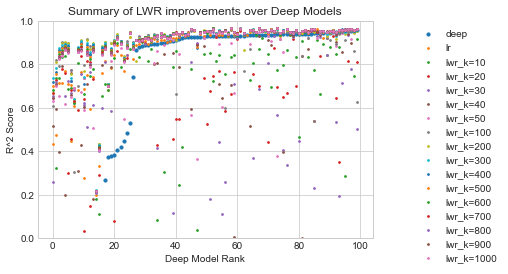

In [14]:
#take 1 is a scatter plot - lets, for each dataset
#graph our deep models by rank - plot - then overlay our knn moels
#plot points

deep_set = scores_df[scores_df["predictor"]=="deep"].sort_values("R2")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df[scores_df["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        s=10
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot.png", bbox_inches='tight')
logging.getLogger().info("Wrote Summary Graph")

In [15]:
scores_df["n_features"] = [deep_models[i].n_features for i in scores_df["model_num"]] 
from matplotlib.colors import Colormap
import seaborn as sns #heatmap of features - pls model - score
class nlcmap(Colormap):
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self.transformed_levels = np.linspace(self.levmin, self.levmax, #uniform spacing along levels (colour segments)
             len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self.transformed_levels)
        return self.cmap((yi-self.levmin) / (self.levmax-self.levmin), alpha)
    
levels = np.concatenate((
    [0, 1],
    [0.6,0.8,0.9,0.95,0.98]
    ))

levels = levels[levels <= 1]
levels.sort()
cmap_nonlin = nlcmap(plt.cm.YlGnBu, levels)


In [16]:
subset = scores_df[["predictor","n_features","R2"]]
subset = subset[np.logical_not(subset["predictor"]=="deep")]
subset = subset[np.logical_not(subset["predictor"]=="lr")]
trans = subset["predictor"].transform(lambda x: int(x.replace("lwr_k=",""))).tolist()
subset.loc[:,"predictor"]=trans
subset=subset.sort_values("predictor",ascending=False)

def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

C:\Users\huonf\AppData\Local\Temp\ipykernel_9356\3702862414.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(sc,label="R2 Score")


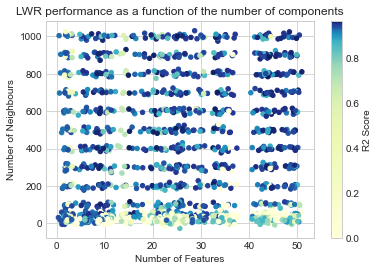

In [17]:
fig, ax = plt.subplots()
sc = ax.scatter(x=rand_jitter(subset["n_features"]), y=rand_jitter(subset["predictor"]), s=20,c=subset["R2"],cmap=cmap_nonlin,vmin=0)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Number of Neighbours")

cbar = fig.colorbar(sc,label="R2 Score")

ax.set_title("LWR performance as a function of the number of components")
plt.savefig(log_dir/f"heat_scatter.png", bbox_inches='tight')